# PLS Regression
I'm following this paper: <https://www.sciencedirect.com/science/article/pii/S1878929316301074?via%3Dihub>

In [2]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (20, 20), 'figure.dpi': 300}
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get Data

In [3]:
from common.data import get_data
from sklearn.utils import shuffle

X, y, ages, sexes, diagnosis = get_data()
selected_measure = "WISC_FSIQ"
y = np.array(y[selected_measure])
X, y, ages, sexes = shuffle(X, y, ages, sexes)

print(f'X: {X.shape} | y: {y.shape} | Age: {ages.shape} | Sex: {sexes.shape} | Diagnosis: {diagnosis.shape}')

X: (678, 34716) | y: (678,) | Age: (678,) | Sex: (678,) | Diagnosis: (678,)


### Group and Average

In [22]:
def group_and_average(X, y, group_size=3):
    X_temp, y_temp = [], []
    
    # Multiply by 2 to enable the splits to be random
    num_sections = X.shape[0] / (group_size * 2)
    X_indices = np.arange(X.shape[0])
    subarray_indices = np.array(np.split(X_indices, num_sections, axis=0))
    
    # Shuffle each section so each time the split is run, the groups are different
    rng = np.random.default_rng()
    rng.shuffle(subarray_indices, axis=1)
    
    for subarray in subarray_indices:
        # Half each section to return to the original group size
        front_half, back_half = subarray[:group_size], subarray[group_size:]
        X_temp.append(np.mean(X[front_half], axis=0))
        X_temp.append(np.mean(X[back_half], axis=0))
        
        y_temp.append(np.mean(y[front_half]))
        y_temp.append(np.mean(y[back_half]))
    
    X_temp, y_temp = shuffle(X_temp, y_temp)
    return np.array(X_temp), np.array(y_temp)


def group_and_average_by_y(X, y, group_size=3):
    # Sort data by target
    sort_indices = np.argsort(y)
    X, y = X[sort_indices], y[sort_indices]
    
    return group_and_average(X, y, group_size)

In [23]:
X, y = group_and_average(X, y)
print("X:", X.shape, "y:", y.shape)

X shape: (226, 34716) y shape: (226,)


### Add Noise

In [33]:
def generate_noise_samples(X, y, num_times):
    X_std = np.std(X, axis=0)
    
    for i in range(0, num_times):
        X_noisy = X + np.random.normal(0, X_std, X.shape)
        X, y = np.append(X, X_noisy, axis=0), np.append(y, y)
    
    return shuffle(X, y)

## Feature selection

### Age Binning

In [4]:
from common.binning import bin_by_age, bin_by_feature

bins = bin_by_feature(X, y, ages, diagnosis)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

Bin 0: (array(['No', 'Unknown', 'Yes'], dtype='<U7'), array([ 15,   6, 205]))
Bin 1: (array(['No', 'Unknown', 'Yes'], dtype='<U7'), array([ 16,  14, 196]))
Bin 2: (array(['No', 'Unknown', 'Yes'], dtype='<U7'), array([ 20,  12, 194]))
---
Bin 1: (226, 34716) | Bin 2: (226, 34716) | Bin 3: (226, 34716)


### IQ Binning

In [21]:
bins = bin_by_feature(X, y, y, 3)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

Bin 0 Range: 47.00 -> 93.00
Bin 1 Range: 93.00 -> 109.00
Bin 2 Range: 109.00 -> 147.00
Bin 1: (226, 34716) | Bin 2: (226, 34716) | Bin 3: (226, 34716)


In [10]:
# X, y = bin_1[0], bin_1[1]
mi_k = 1000

## Modeling Using PLS Regression

In [11]:
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline

In [12]:
pipe = make_pipeline(StandardScaler(), SelectKBest(mutual_info_regression, k=mi_k), 
                     PLSRegression(n_components=2))

### K-fold Cross-validation

In [15]:
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=251183)
train_scores, test_scores = [], []

for train_index, test_index in rkf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    train_scores.append(r2_score(y_train, y_train_pred))
    test_scores.append(r2_score(y_test, y_test_pred))

avg_train_score, avg_test_score = np.mean(train_scores), np.mean(test_scores)

print(f"Avg train score: {avg_train_score:.2f}")
print(f"Avg test score: {avg_test_score:.2f}")

Avg train score: 0.30
Avg test score: 0.09


### Iteration with Percentage

**Standard PLS Model**

In [8]:
num_component = 2
train_scores, test_scores = [], []
pearsonr_scores, spearmanr_scores = [], []
coefs = []

for i in range(0, 1000):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=True)
    
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)[:, 0]
    
    train_scores.append(r2_score(y_train, y_train_pred))
    test_scores.append(r2_score(y_test, y_test_pred))
    pearsonr_scores.append(stats.pearsonr(y_test, y_test_pred)[0])
    spearmanr_scores.append(stats.spearmanr(y_test, y_test_pred)[0])
    coefs.append(pls.coef_)
    
    if (i == 0):
        print(X_train.shape, X_test.shape)

avg_train_score, avg_test_score = np.mean(train_scores), np.mean(test_scores)
avg_pearsonr, avg_spearmanr = np.mean(pearsonr_scores), np.mean(spearmanr_scores)
avg_coef = np.mean(coefs, axis=0)

print(f"Avg train score: {avg_train_score:.4f}")
print(f"Avg test score: {avg_test_score:.4f}")
print(f"Avg pearson: {avg_pearsonr:.4f}")
print(f"Avg spearman: {avg_spearmanr:.4f}")

(474, 34716) (204, 34716)
Avg train score: 0.3361
Avg test score: 0.0966
Avg pearson: 0.3351
Avg spearman: 0.3448


In [14]:
X_t = StandardScaler().fit_transform(X)
y_pred = np.dot(X_t, avg_coef) + np.mean(y)
print(r2_score(y, y_pred))

0.3022999020803683


**PLS on Group-and-Average Data**

In [23]:
num_component = 2
train_scores, test_scores = [], []
pearsonr_scores, spearmanr_scores = [], []
coefs = []

for j in range(0, 10):
    X_group, y_group = group_and_average_by_y(X, y)
    mi = SelectKBest(mutual_info_regression, k=3000)
    X_group = mi.fit_transform(X_group, y_group)
    
    for i in range(0, 10):
        X_train, X_test, y_train, y_test = train_test_split(
            X_group, y_group, test_size=0.3, shuffle=True)

        pls = PLSRegression(n_components=num_component)
        pls.fit(X_train, y_train)

        y_train_pred = pls.predict(X_train)
        y_test_pred = pls.predict(X_test)[:, 0]

        train_scores.append(r2_score(y_train, y_train_pred))
        test_scores.append(r2_score(y_test, y_test_pred))
        pearsonr_scores.append(stats.pearsonr(y_test, y_test_pred)[0])
        spearmanr_scores.append(stats.spearmanr(y_test, y_test_pred)[0])
        coefs.append(pls.coef_)

avg_train_score, avg_test_score = np.mean(train_scores), np.mean(test_scores)
avg_pearsonr, avg_spearmanr = np.mean(pearsonr_scores), np.mean(spearmanr_scores)
avg_coef = np.mean(coefs, axis=0)

print(f'Measure: {selected_measure}')
print(f"Avg train score: {avg_train_score:.3f}")
print(f"Avg test score: {avg_test_score:.3f}")
print(f"Avg pearson: {avg_pearsonr:.3f}")
print(f"Avg spearman: {avg_spearmanr:.3f}")

Measure: WISC_FSIQ
Avg train score: 0.607
Avg test score: 0.346
Avg pearson: 0.603
Avg spearman: 0.626


In [29]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lin_reg_train = LinearRegression().fit(y_train, y_train_pred)
y_train_pred_lin_reg = lin_reg_train.predict(y_train)

lin_reg_test = LinearRegression().fit(y_test, y_test_pred)
y_test_pred_lin_reg = lin_reg_test.predict(y_test)

lin_reg_train_score = lin_reg_train.score(y_train, y_train_pred)
lin_reg_test_score = lin_reg_test.score(y_test, y_test_pred)
print("Train r^2:", lin_reg_train_score)
print("Test r^2:", lin_reg_test_score)

Train r^2: 0.885153843693589
Test r^2: 0.7108456340752947


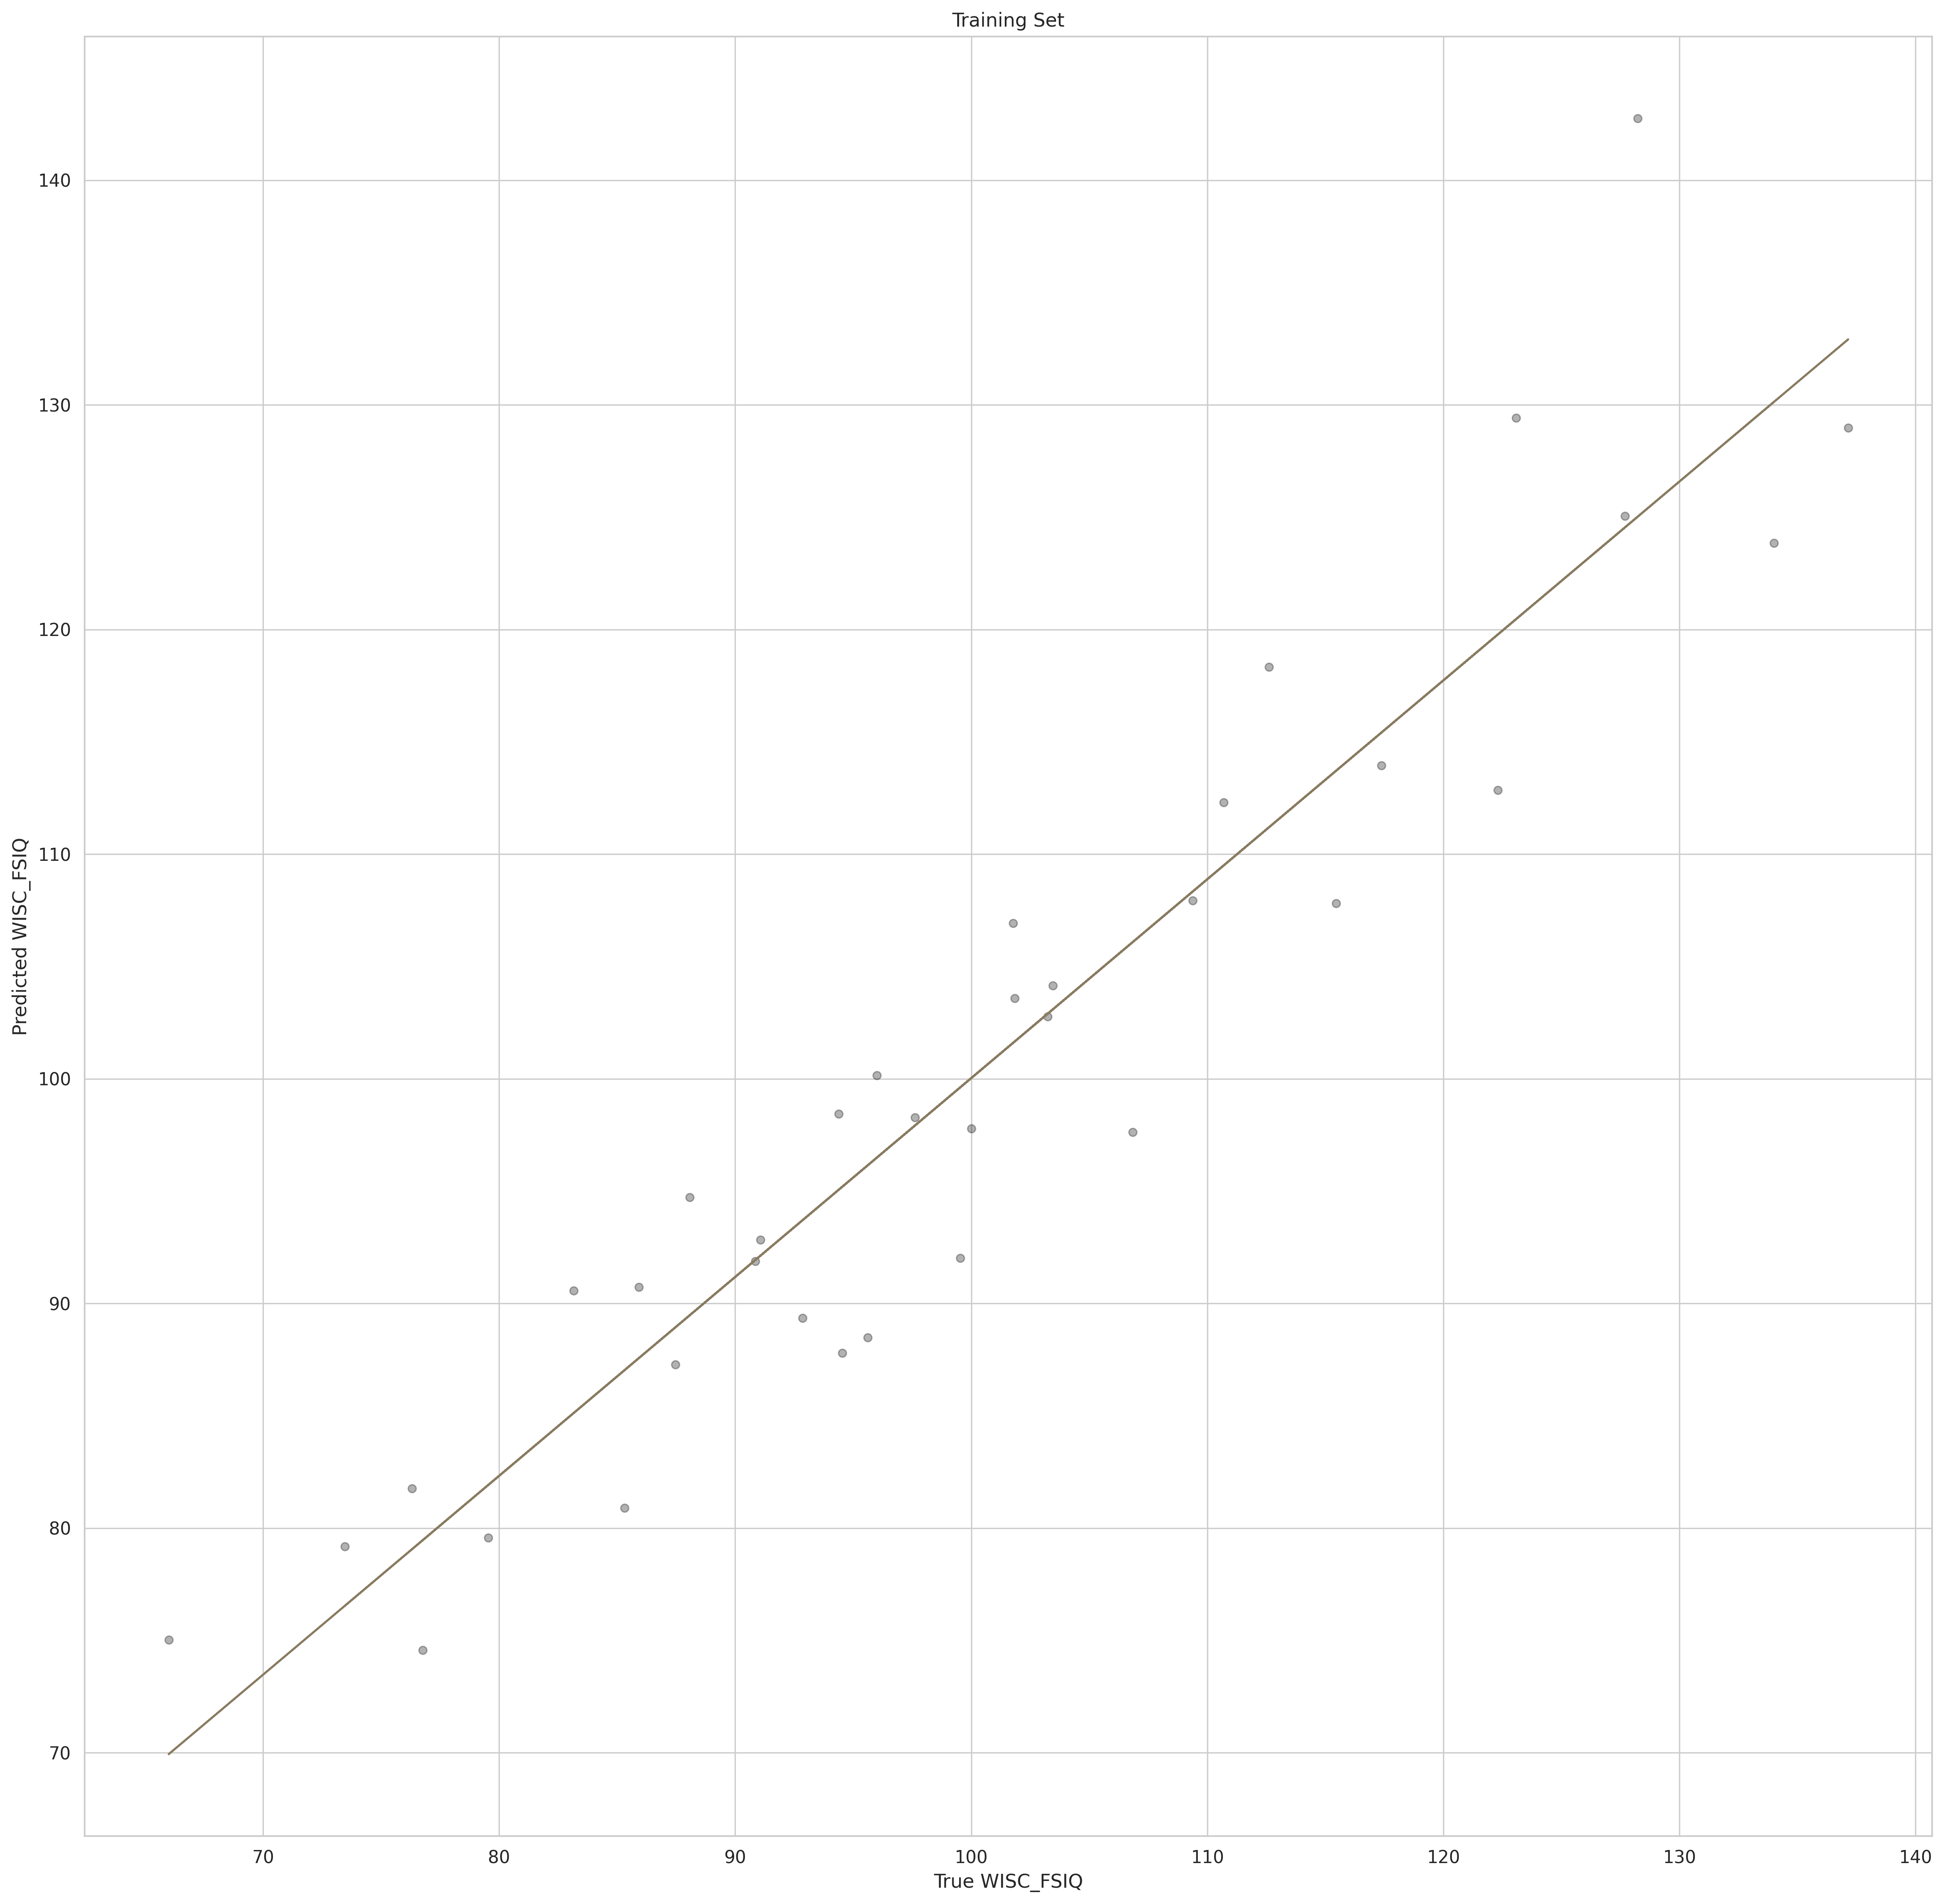

In [30]:
plt.scatter(y_train, y_train_pred, alpha=0.3, color='black')
plt.plot(y_train, y_train_pred_lin_reg, color='#897B61')
plt.title("Training Set")
plt.xlabel(f'True {selected_measure}')
plt.ylabel(f'Predicted {selected_measure}')
# plt.annotate(f"r-squared = {avg_train_score:.3f}", (6, 16))
plt.show()

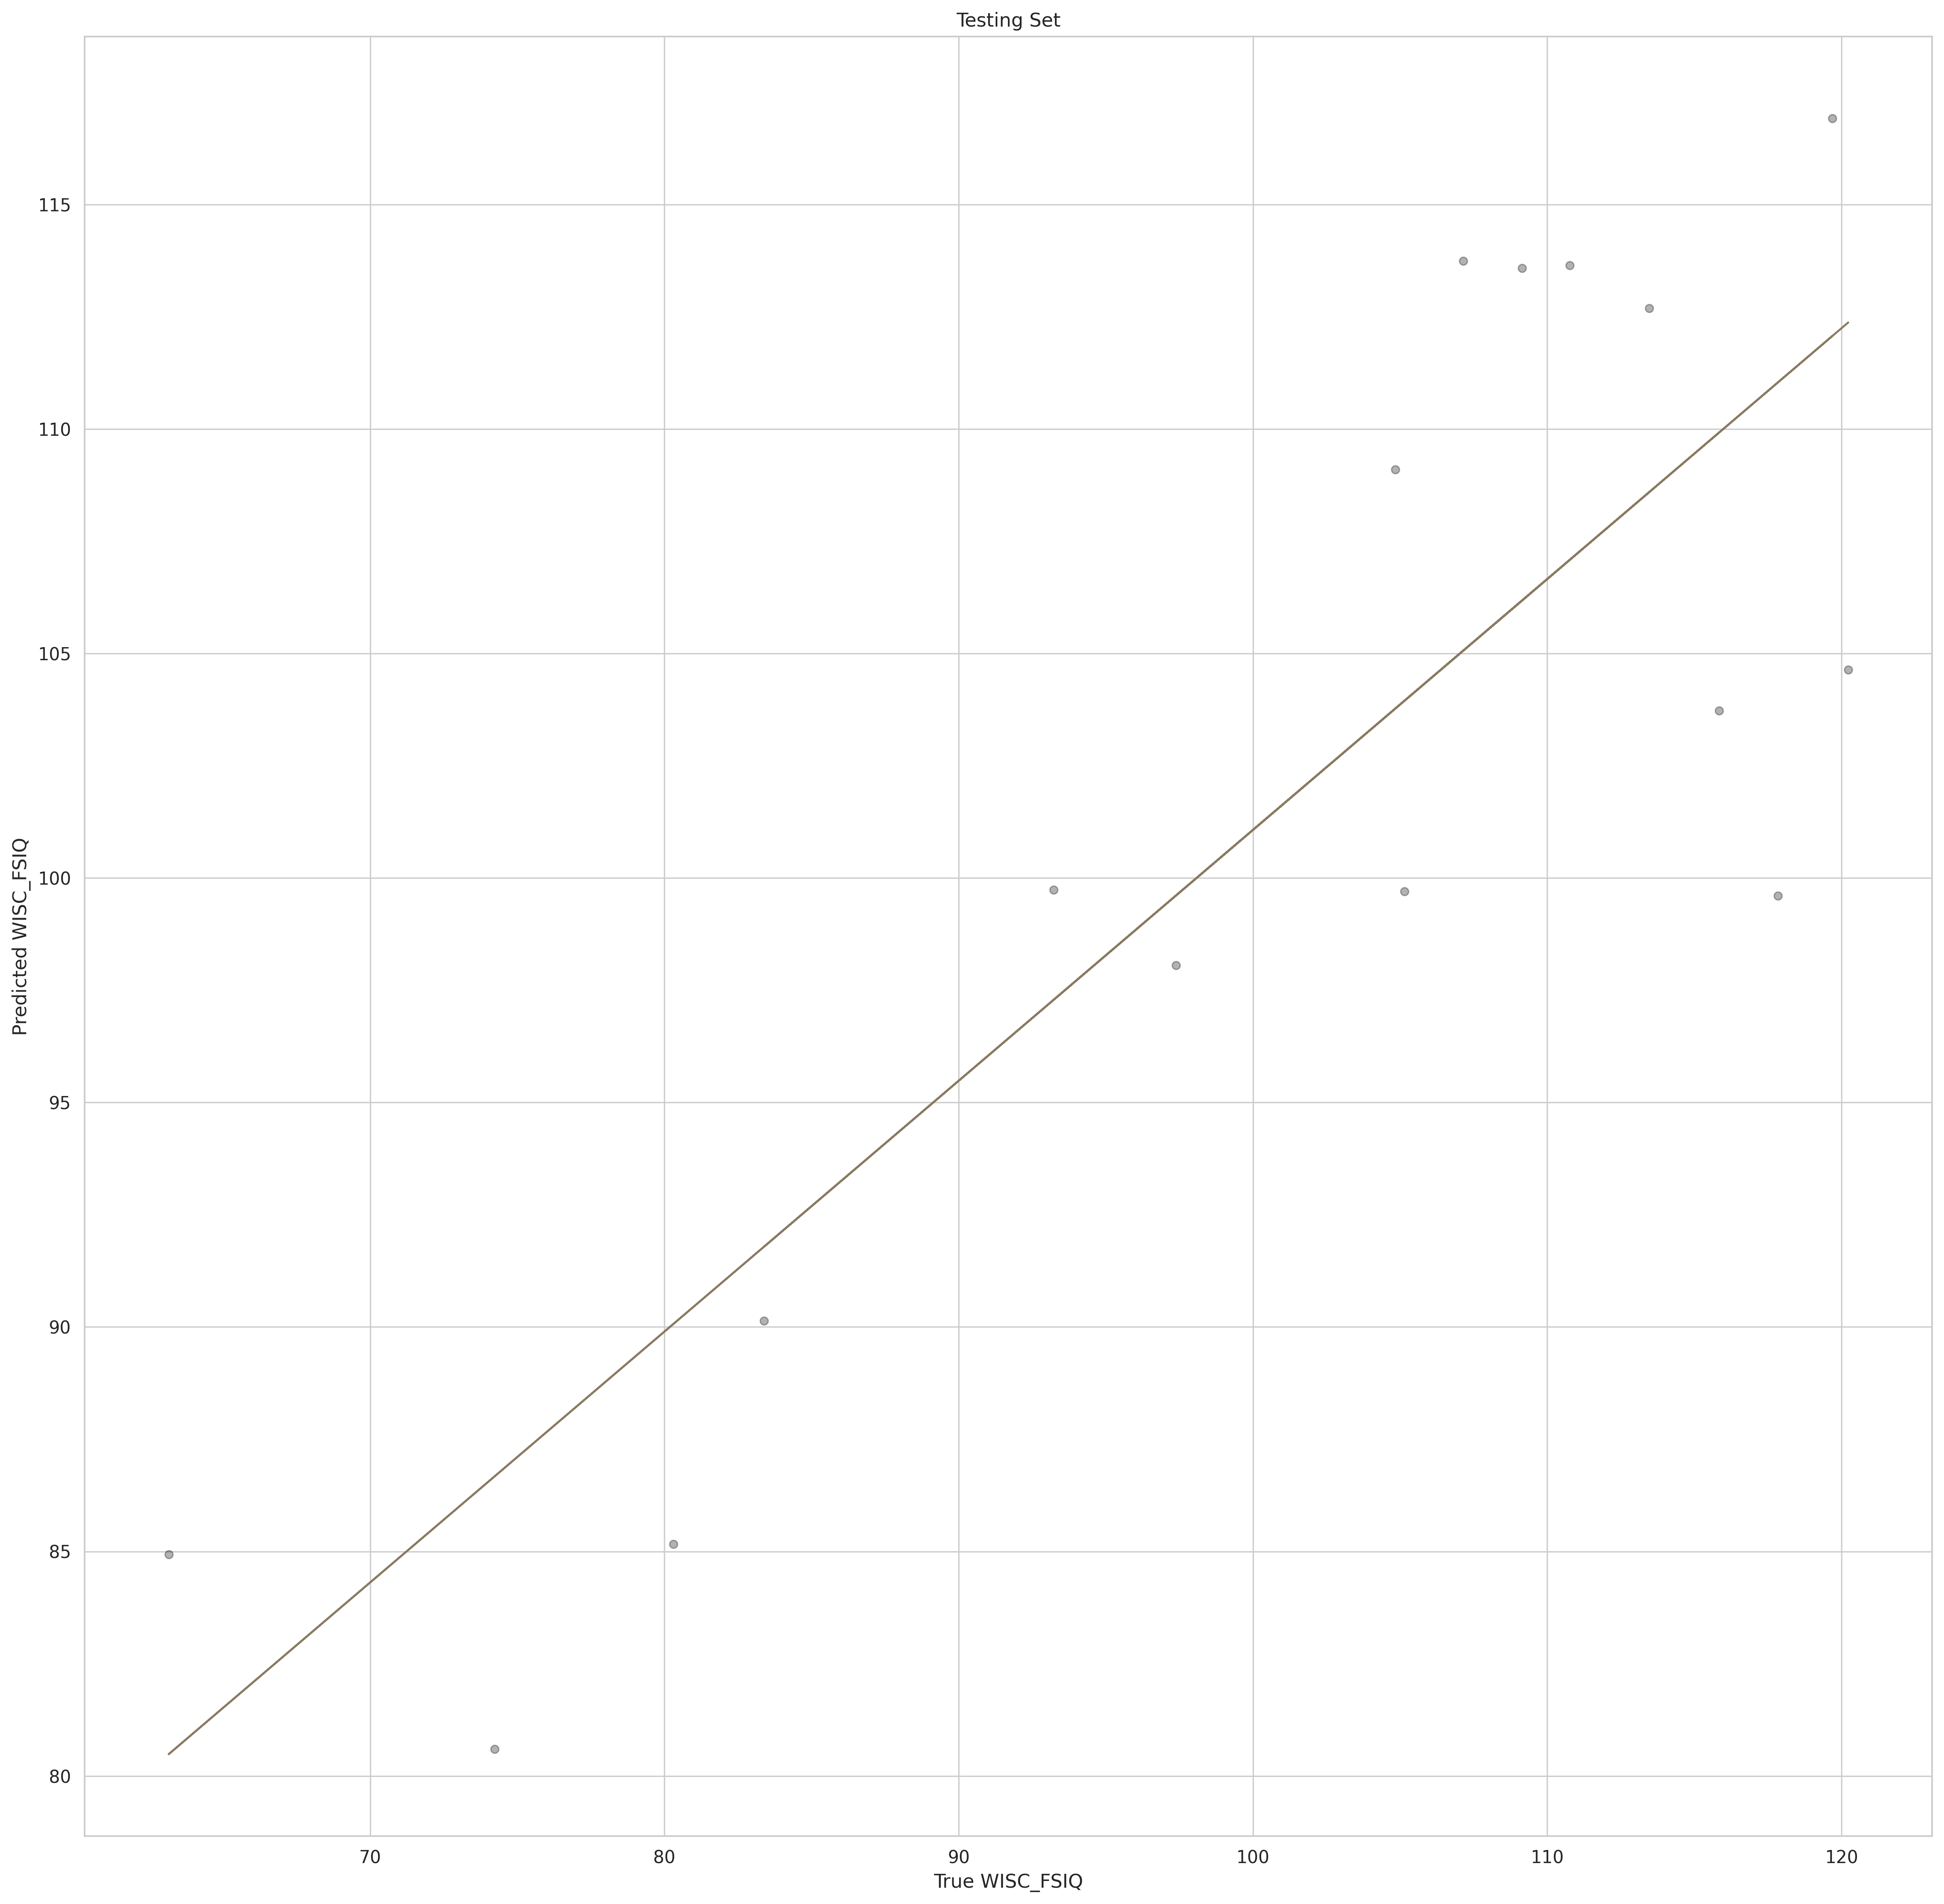

In [31]:
plt.scatter(y_test, y_test_pred, alpha=0.3, color='black')
plt.plot(y_test, y_test_pred_lin_reg, color='#897B61')
plt.title("Testing Set")
plt.xlabel(f'True {selected_measure}')
plt.ylabel(f'Predicted {selected_measure}')
# plt.annotate(f"r-squared = {lin_reg_test_score:.2f}", (60, 87))
plt.show()

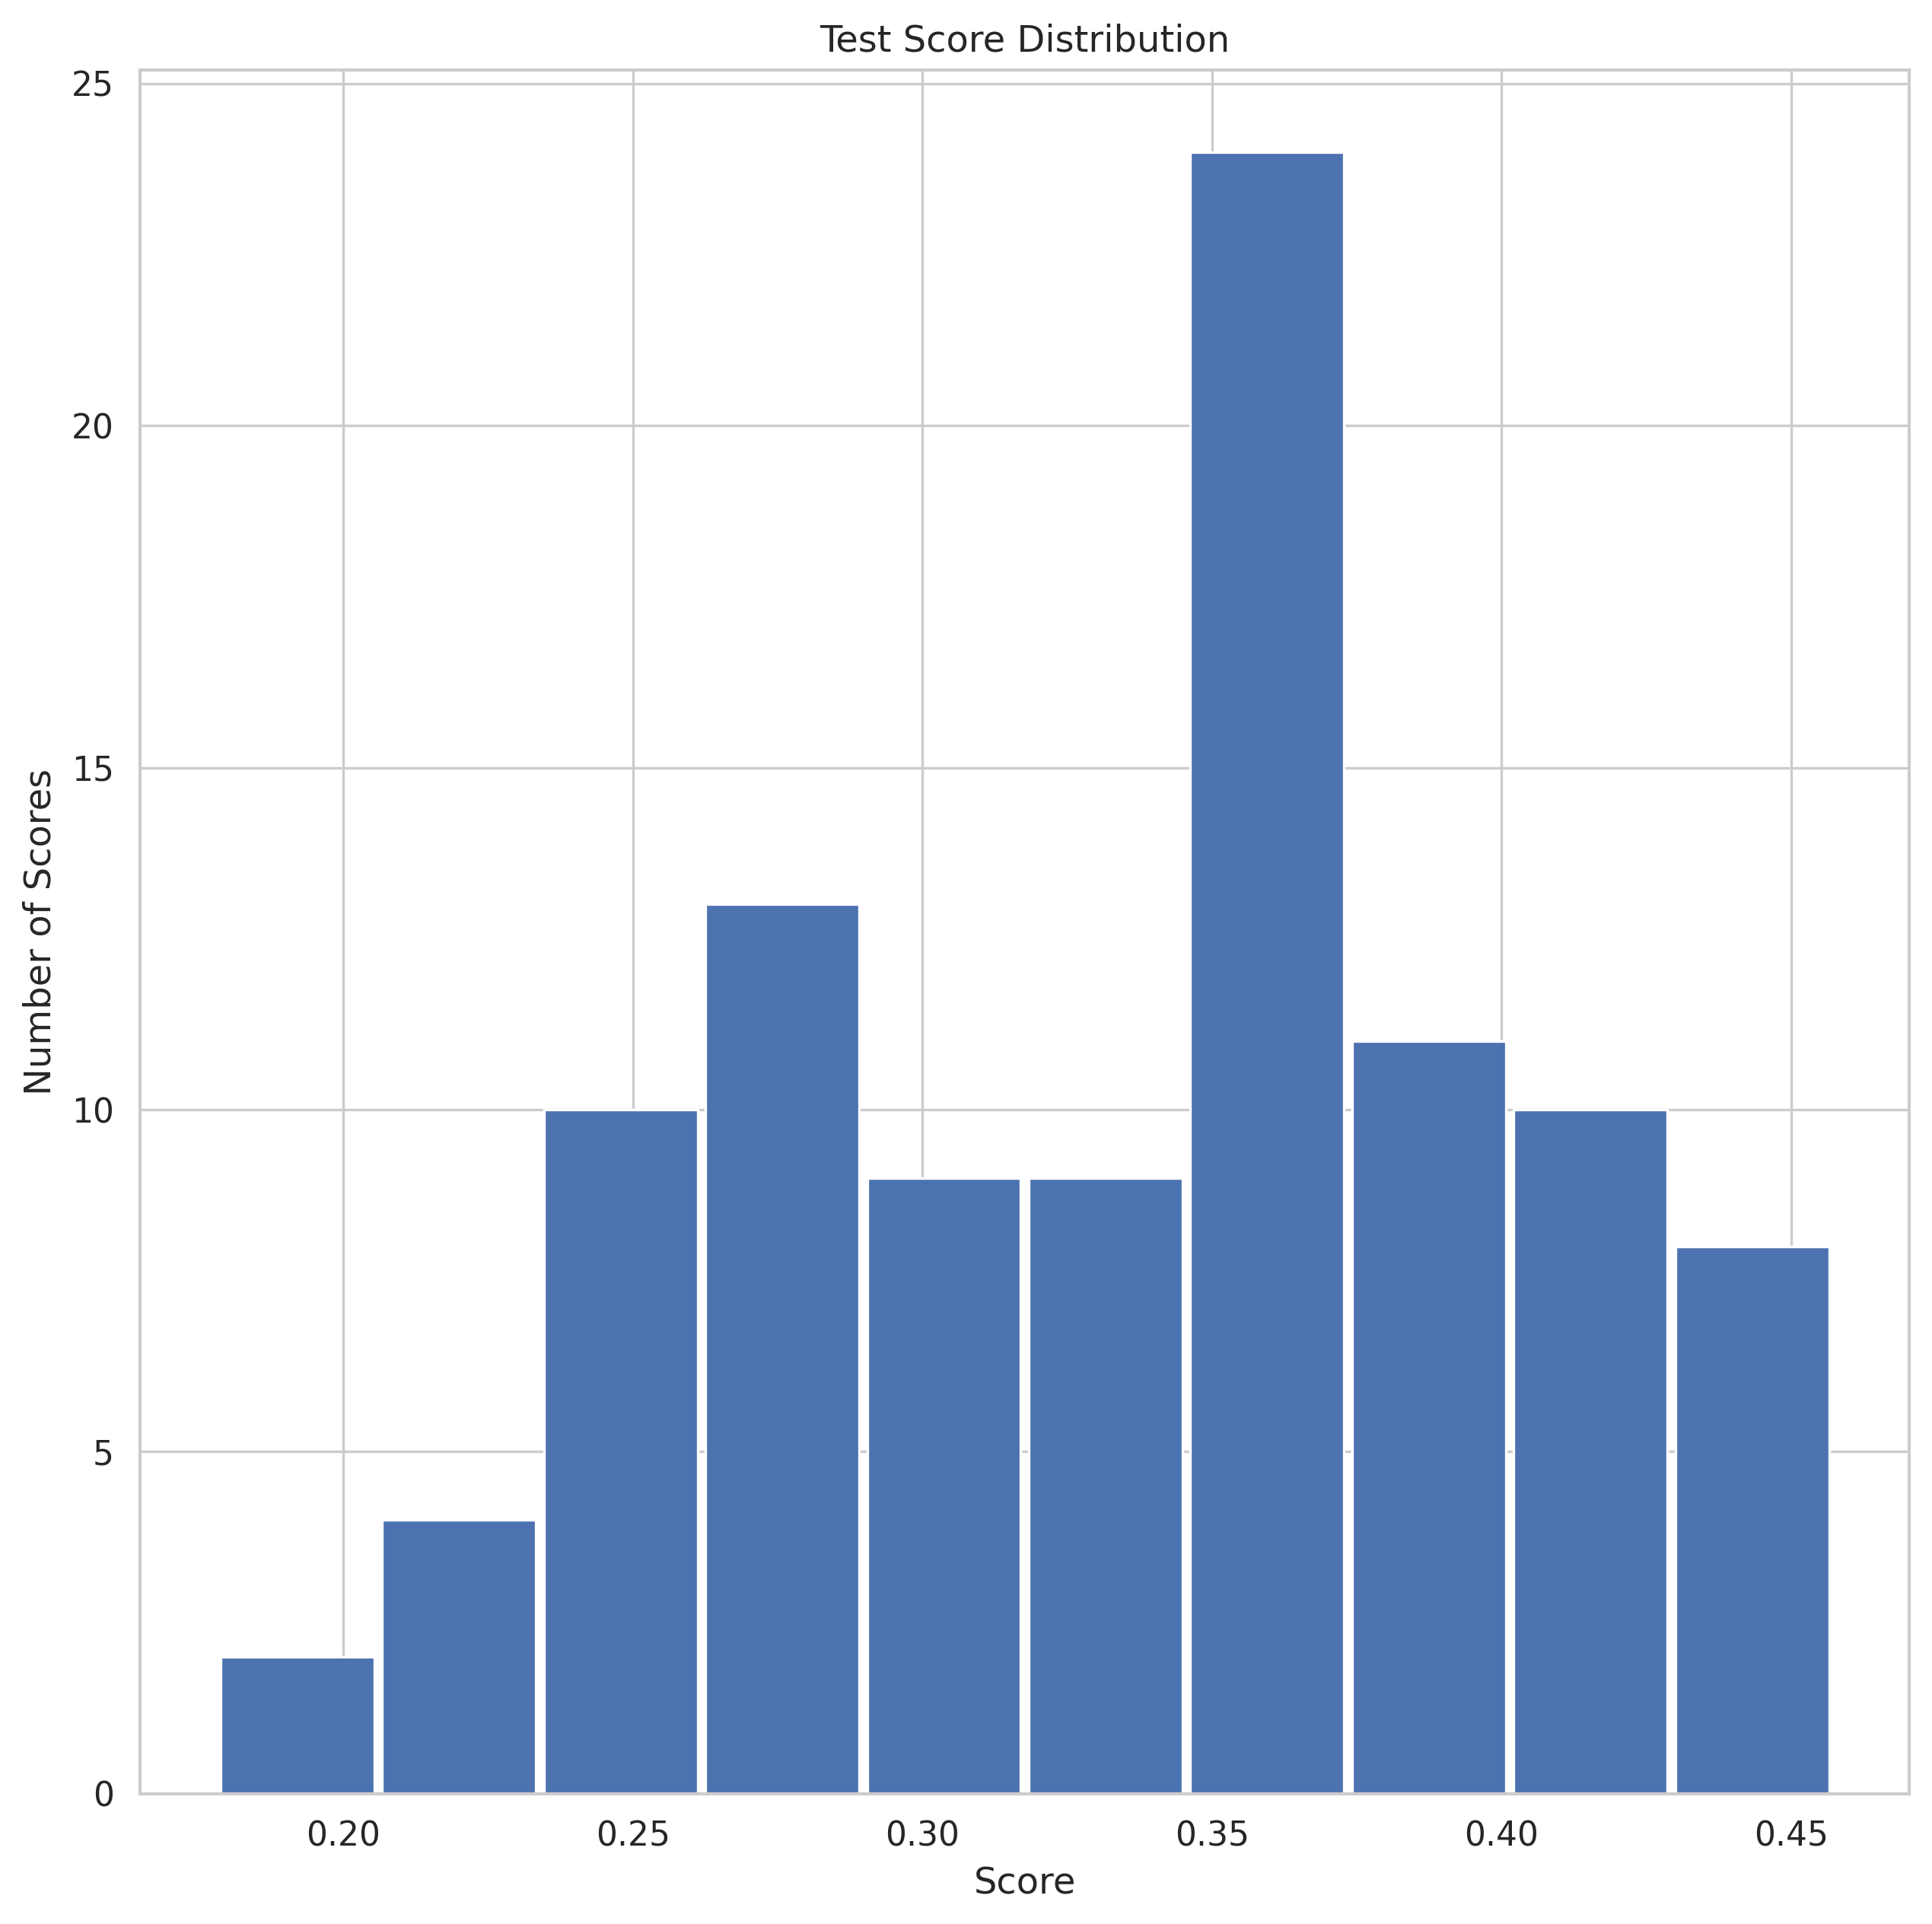

In [16]:
plt.figure(1, figsize=(10, 10))
plt.hist(x=test_scores, rwidth=0.95)
plt.title("Test Score Distribution")
plt.xlabel('Score')
plt.ylabel('Number of Scores')
plt.show()

## Analyze PLS Coefficients

### Plot

(34716,) -0.3135089625610453 0.27058777392301286


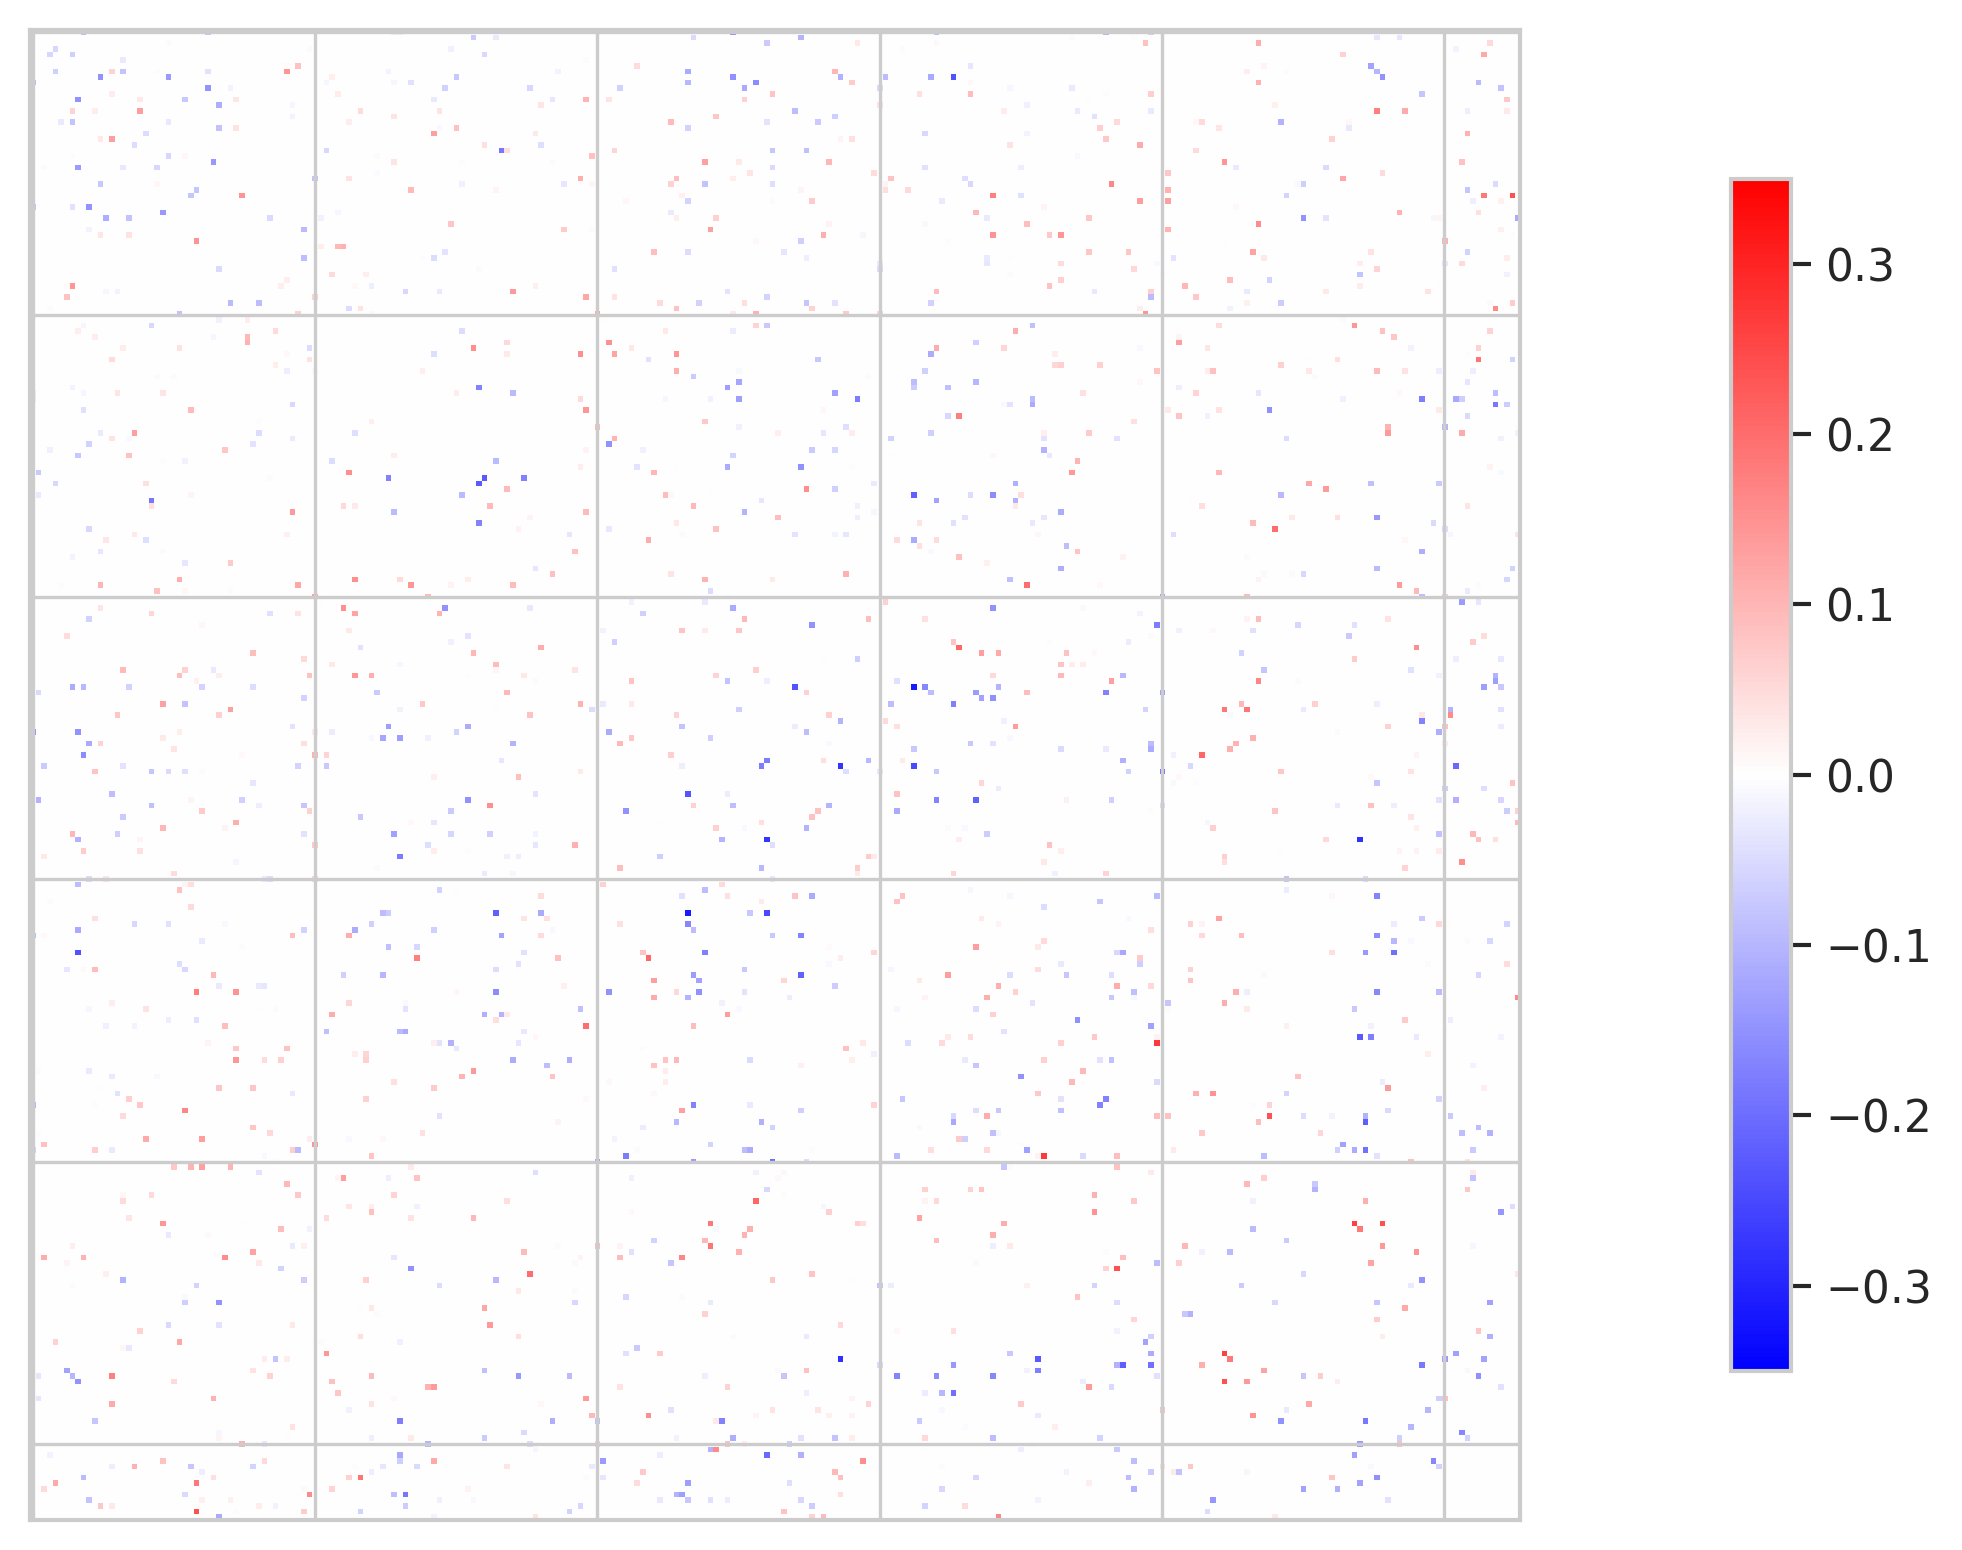

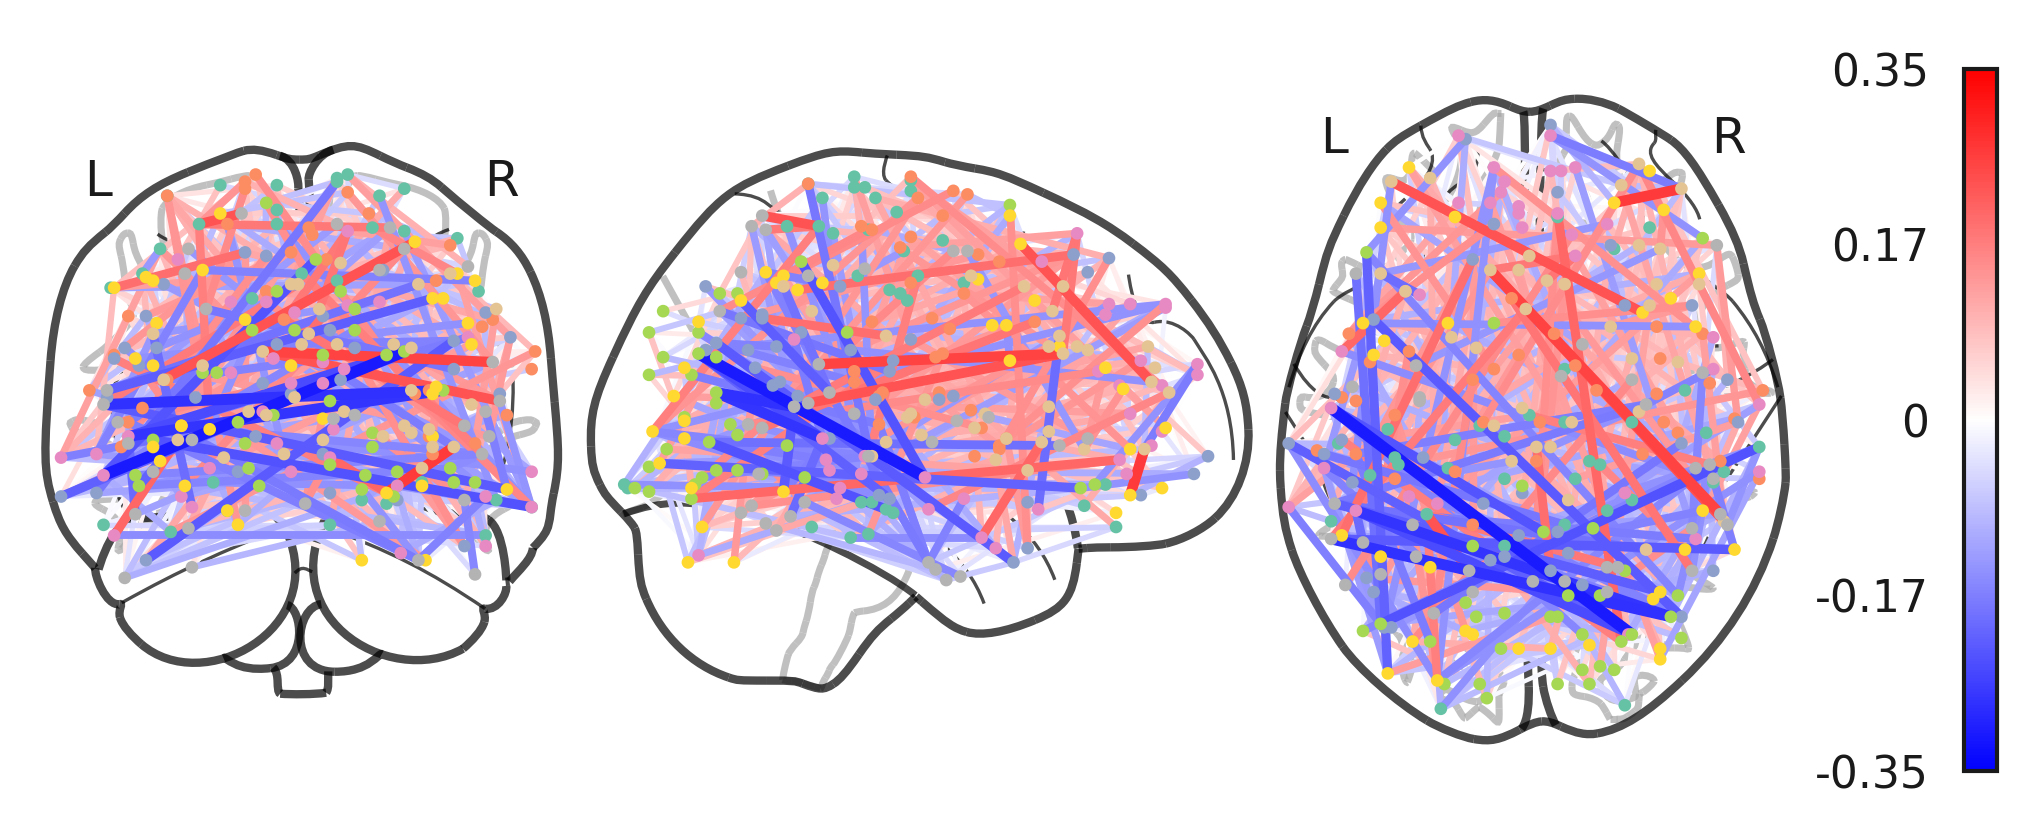

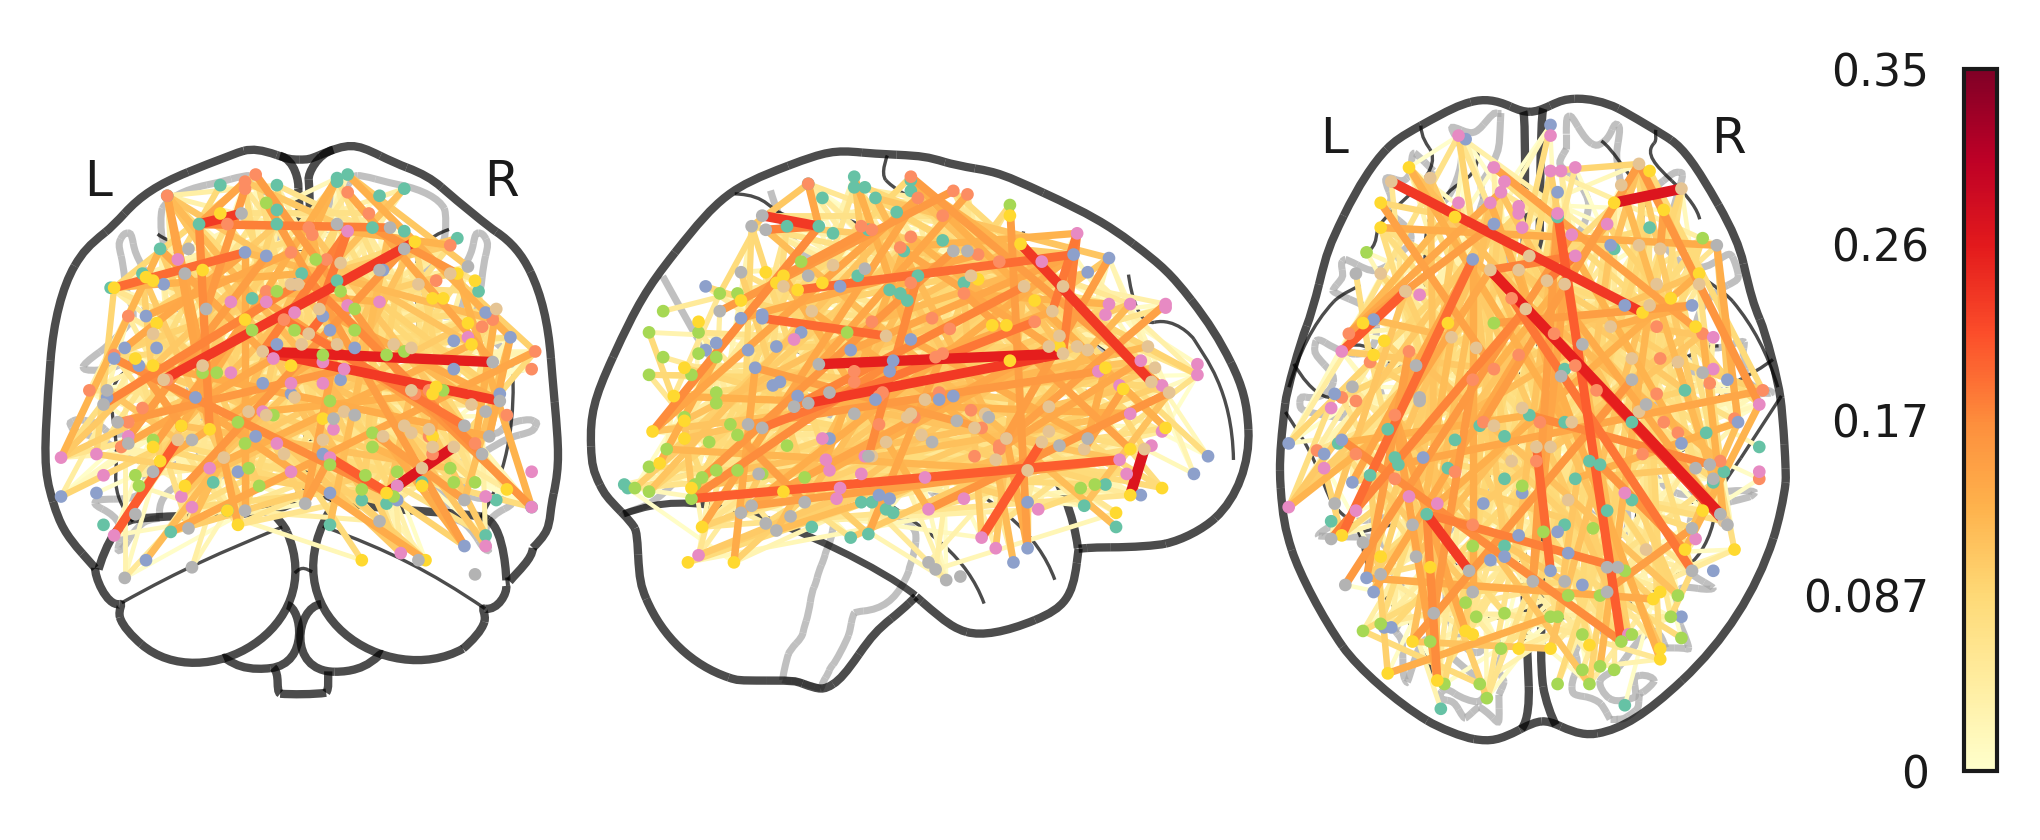

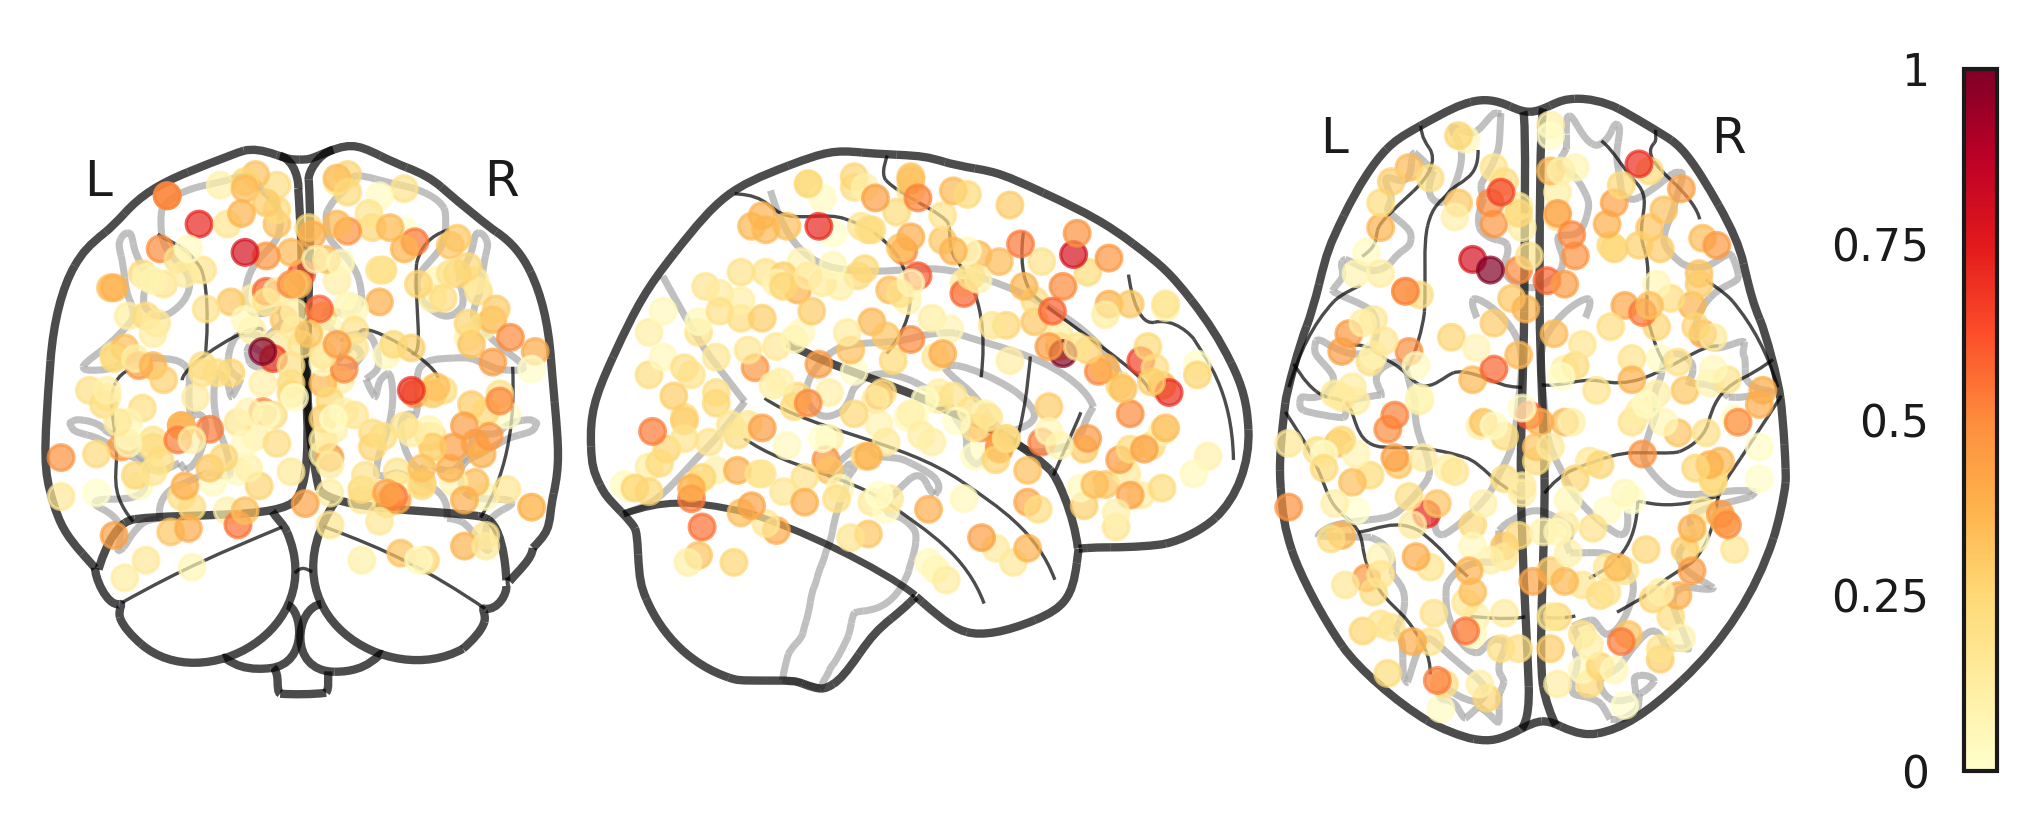

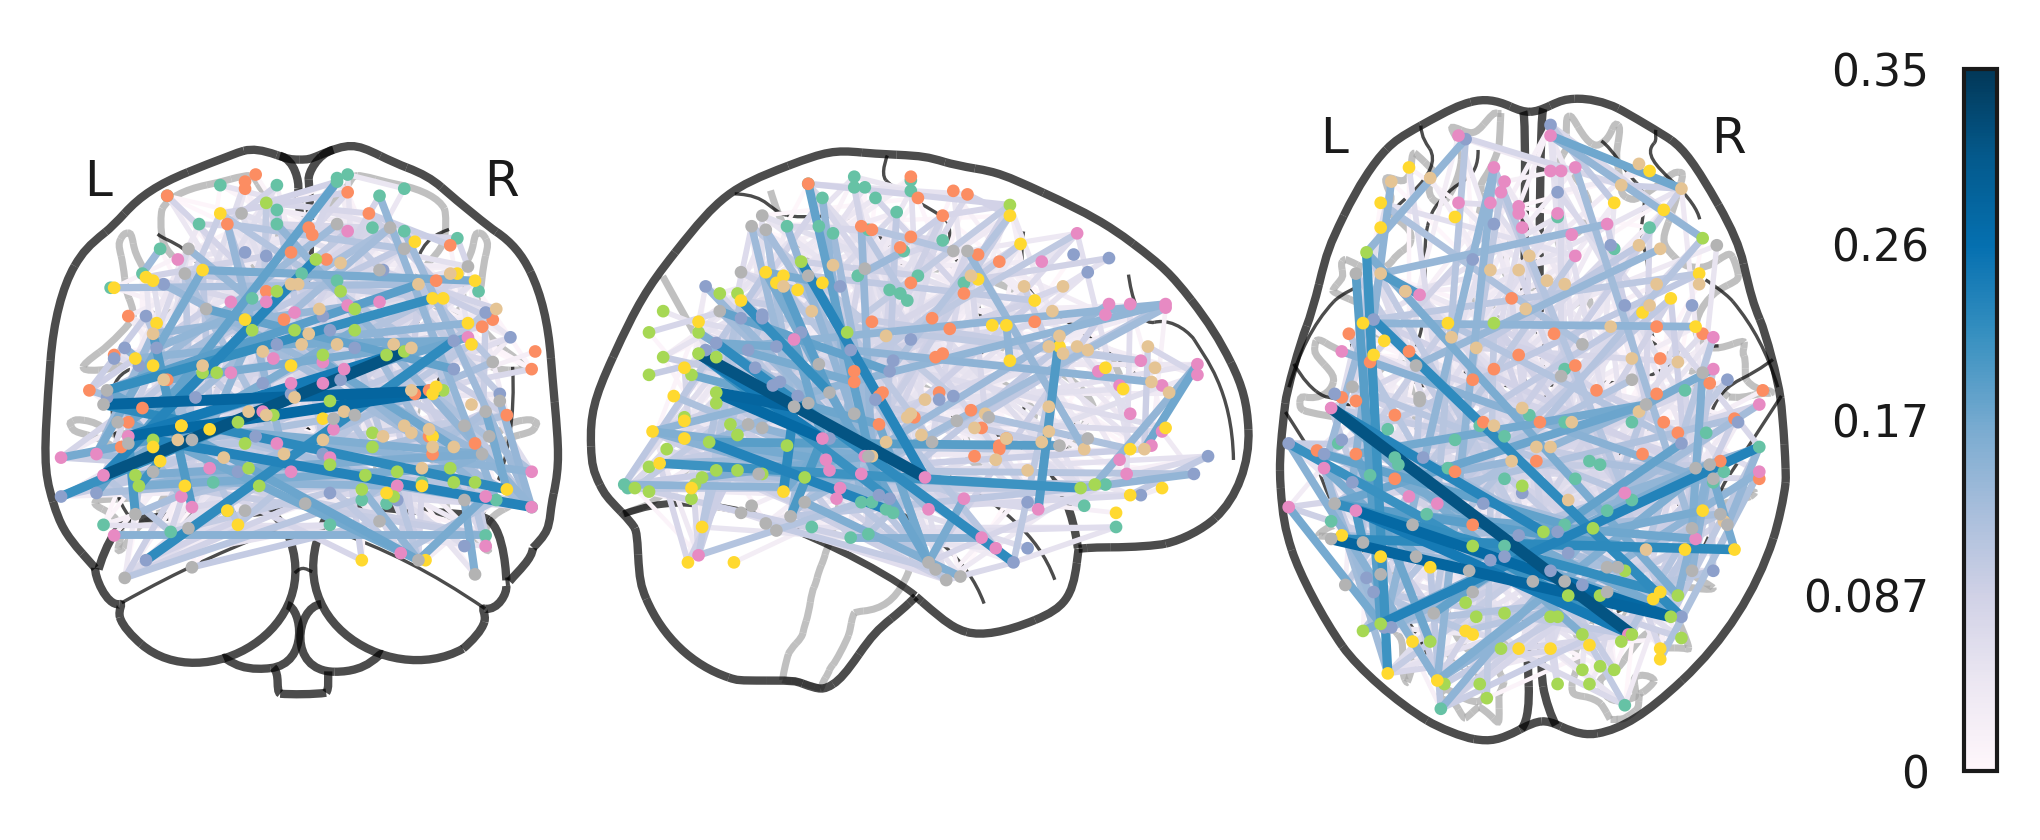

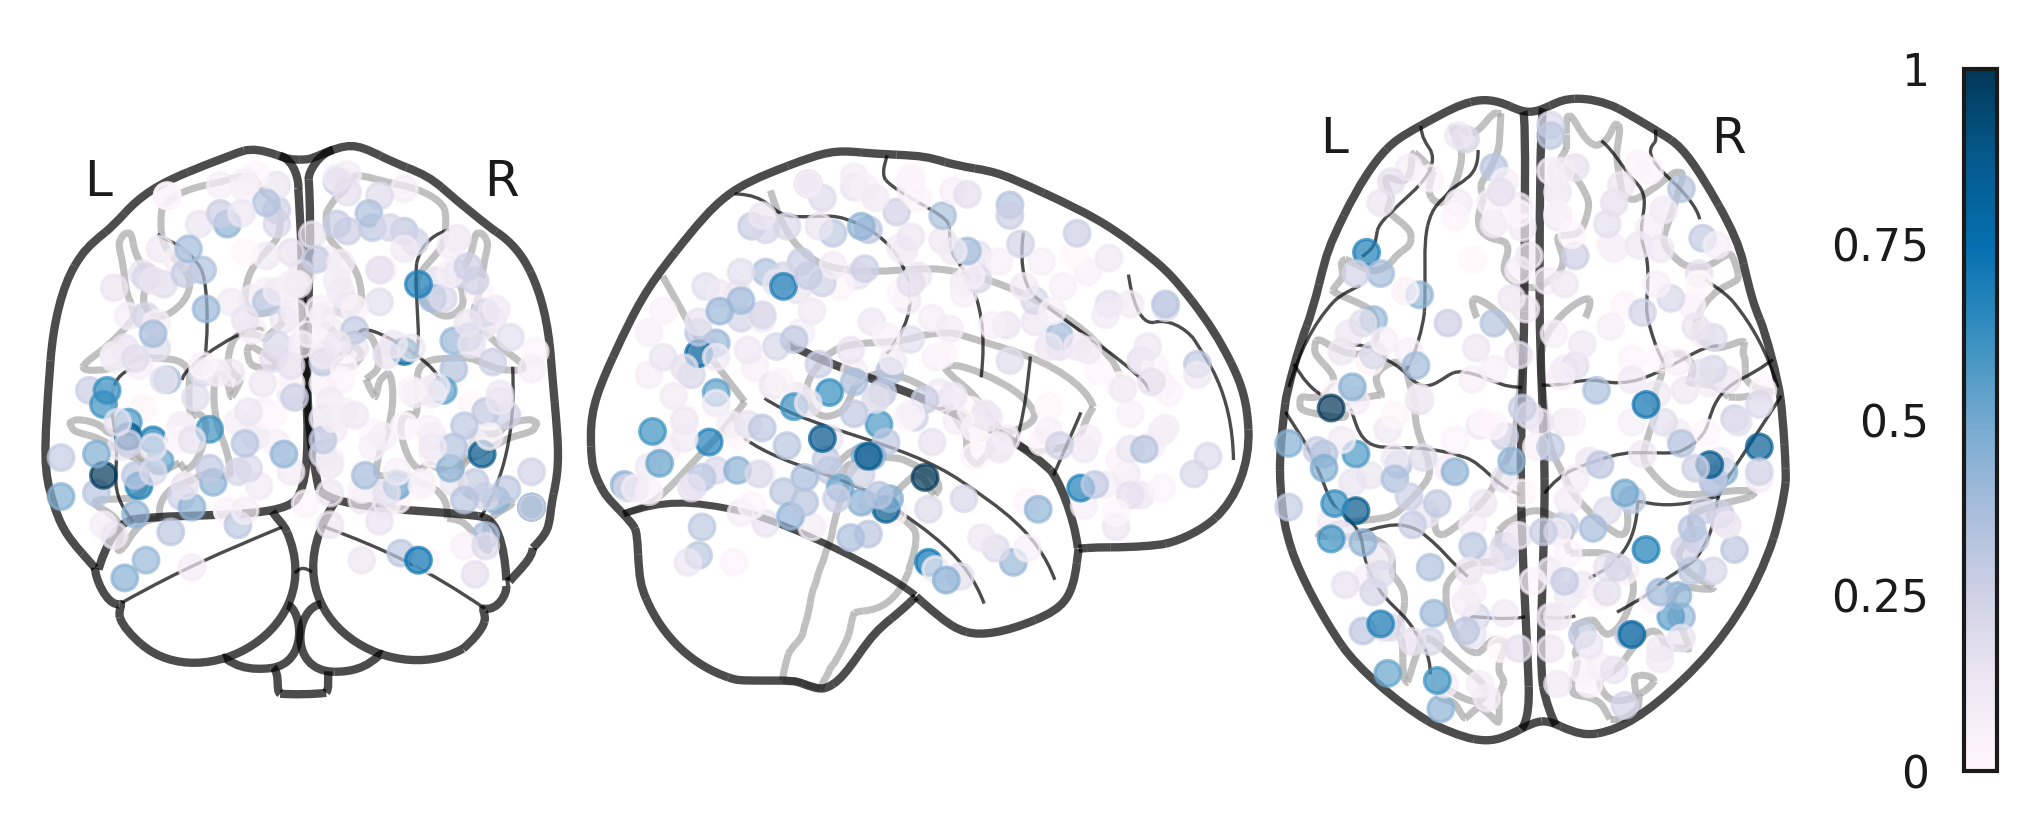

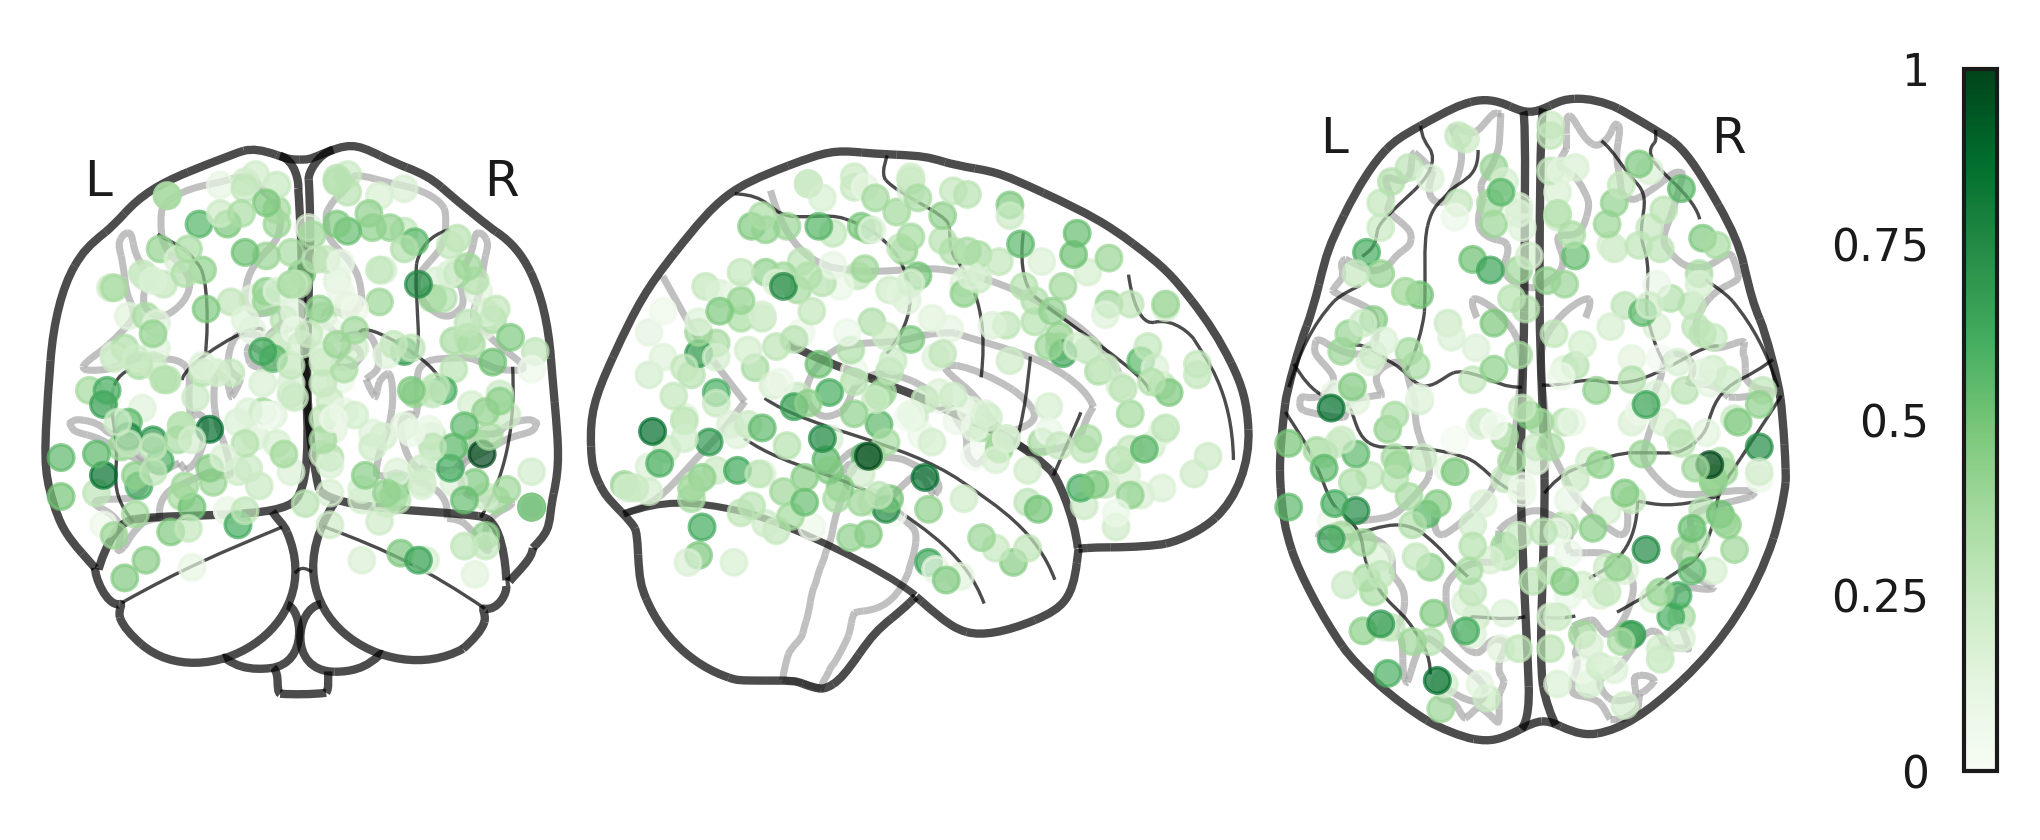

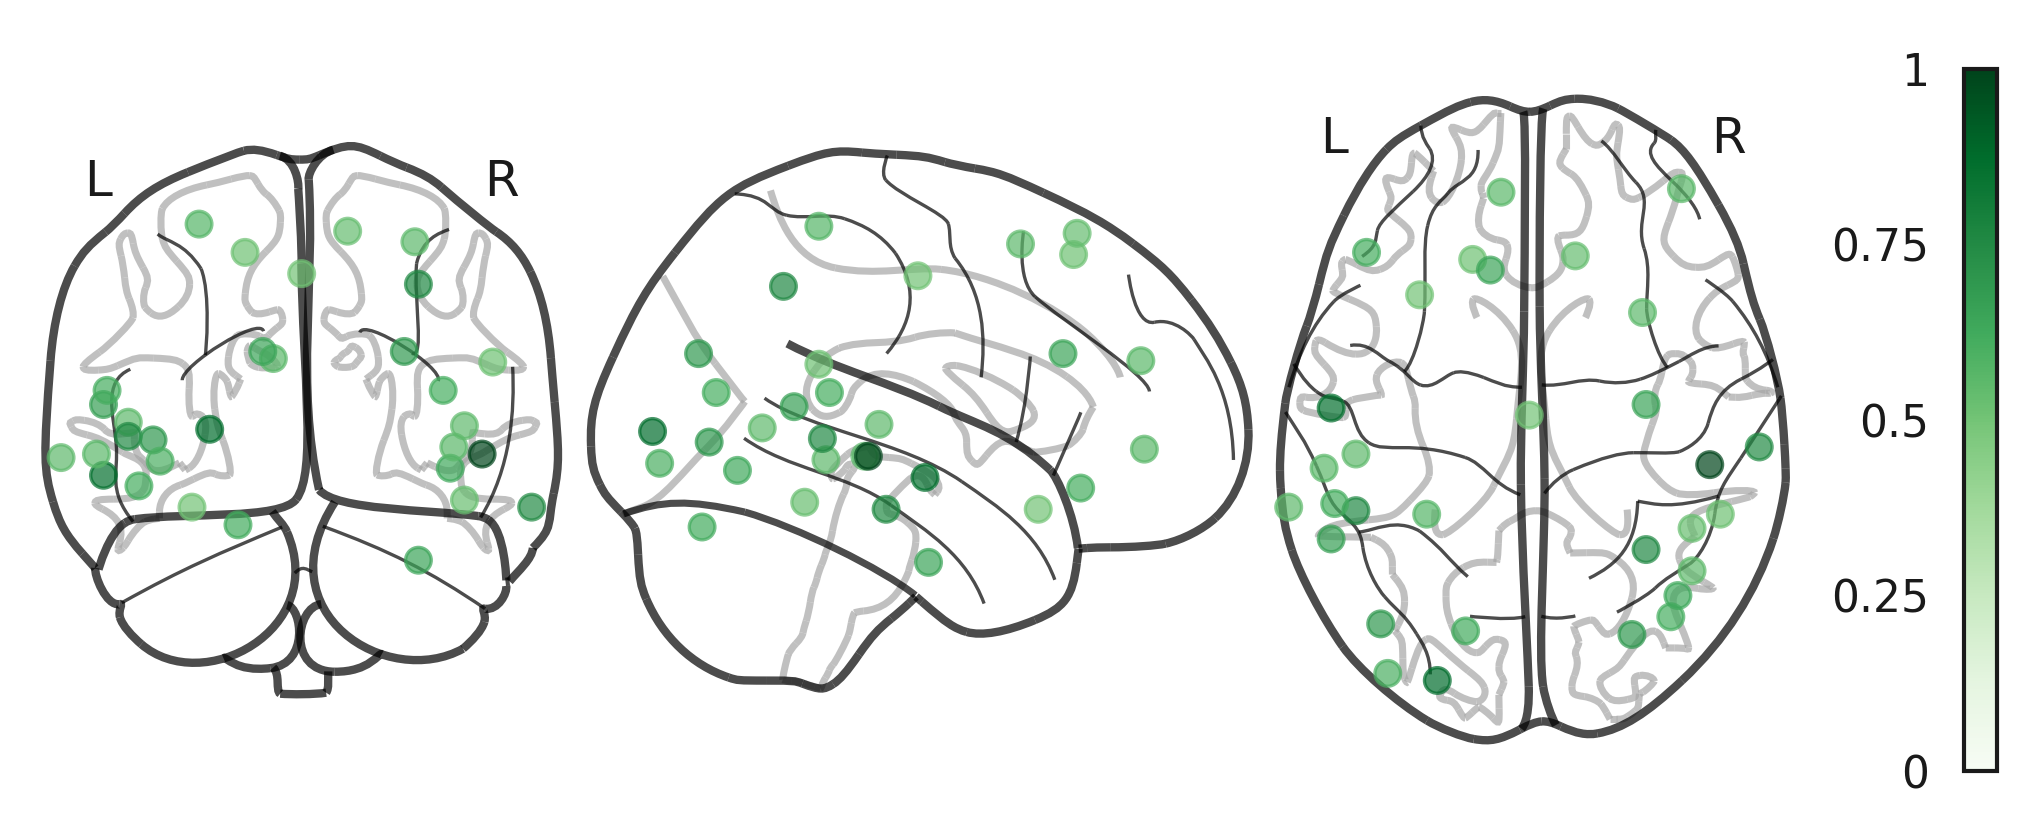

In [12]:
from common.plotting import plot_connections

pls_coef = mi.inverse_transform(avg_coef.T)[0]
print(pls_coef.shape, np.min(pls_coef), np.max(pls_coef))

plot_connections(pls_coef, -0.35, 0.35)

(264,) (264,)
[[ 32  14  56]
 [-18 -76 -24]
 [-10  -2  42]
 [  5  23  37]
 [ -8  48  23]
 [  0 -15  47]
 [-16  29  53]
 [-29 -43  61]
 [ 31  56  14]
 [-11  26  25]] [0.54652292 0.55590578 0.58247092 0.58599178 0.65889669 0.61792489
 0.79029503 0.72268657 0.70438368 1.        ]
[[-55 -40  14]
 [-42 -74   0]
 [ 33 -12 -34]
 [-46  31 -13]
 [ 33 -53  44]
 [ 29 -77  25]
 [-56 -13 -10]
 [-49 -42   1]
 [ 65 -24 -19]
 [ 51 -29  -4]] [0.63402112 0.68103181 0.73210149 0.6899601  0.6925454  0.80676884
 1.         0.87589462 0.8580287  0.87734981]


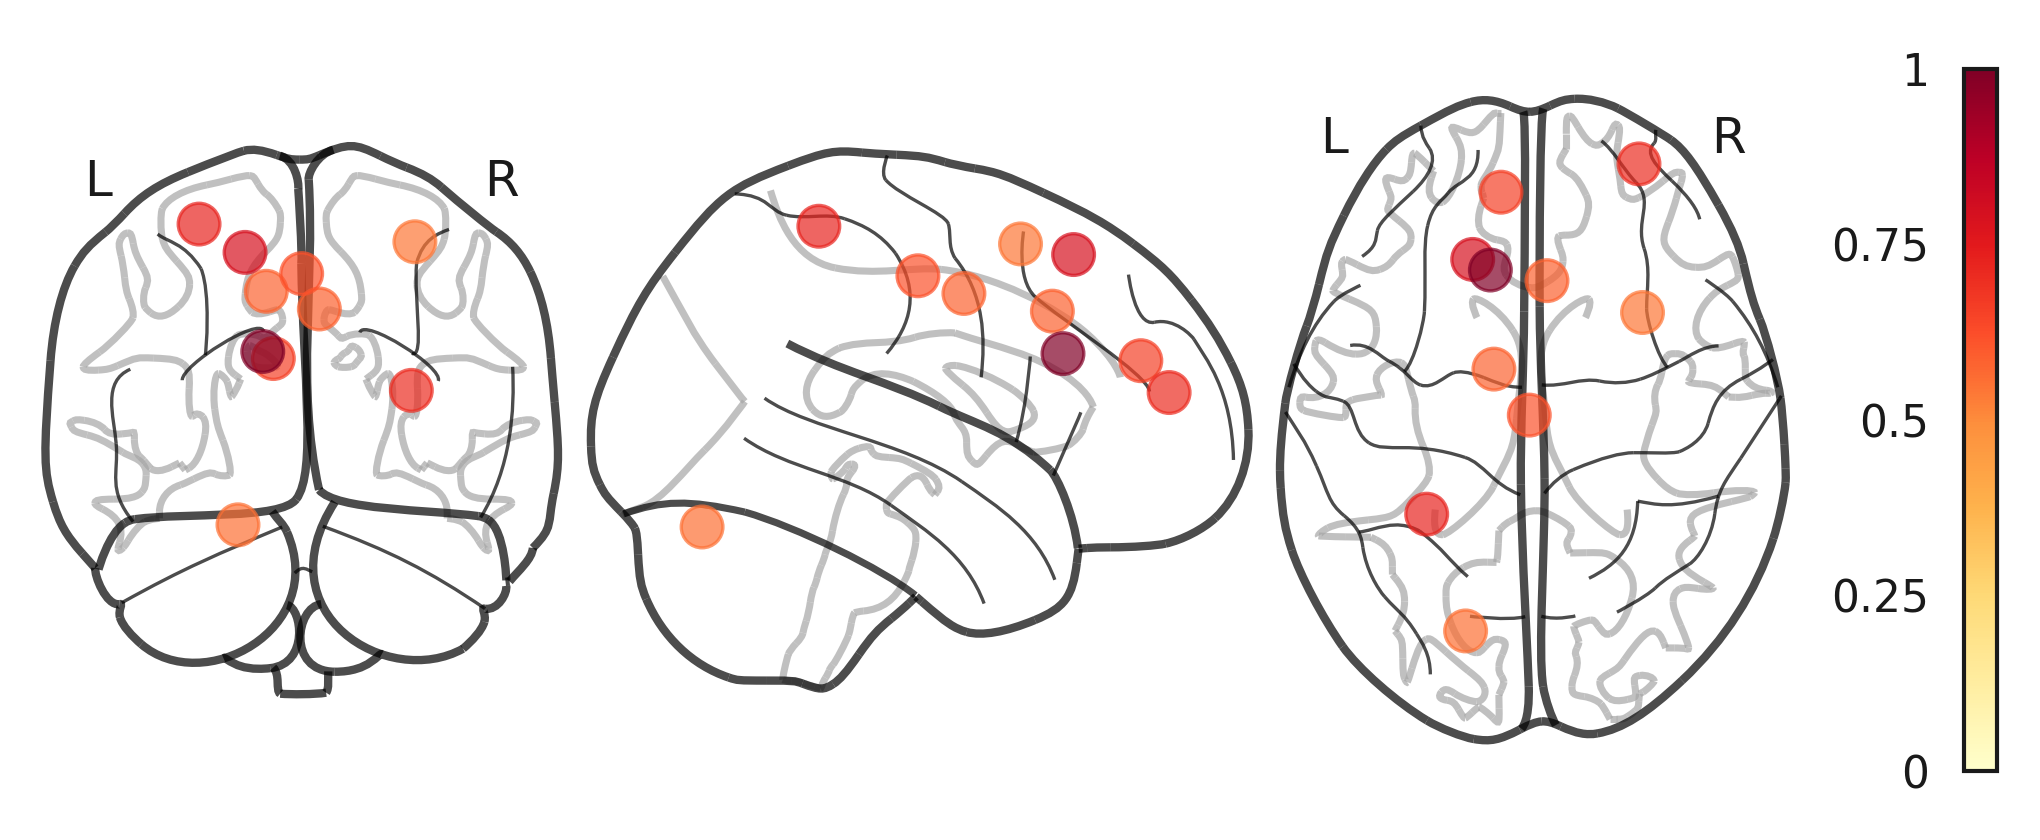

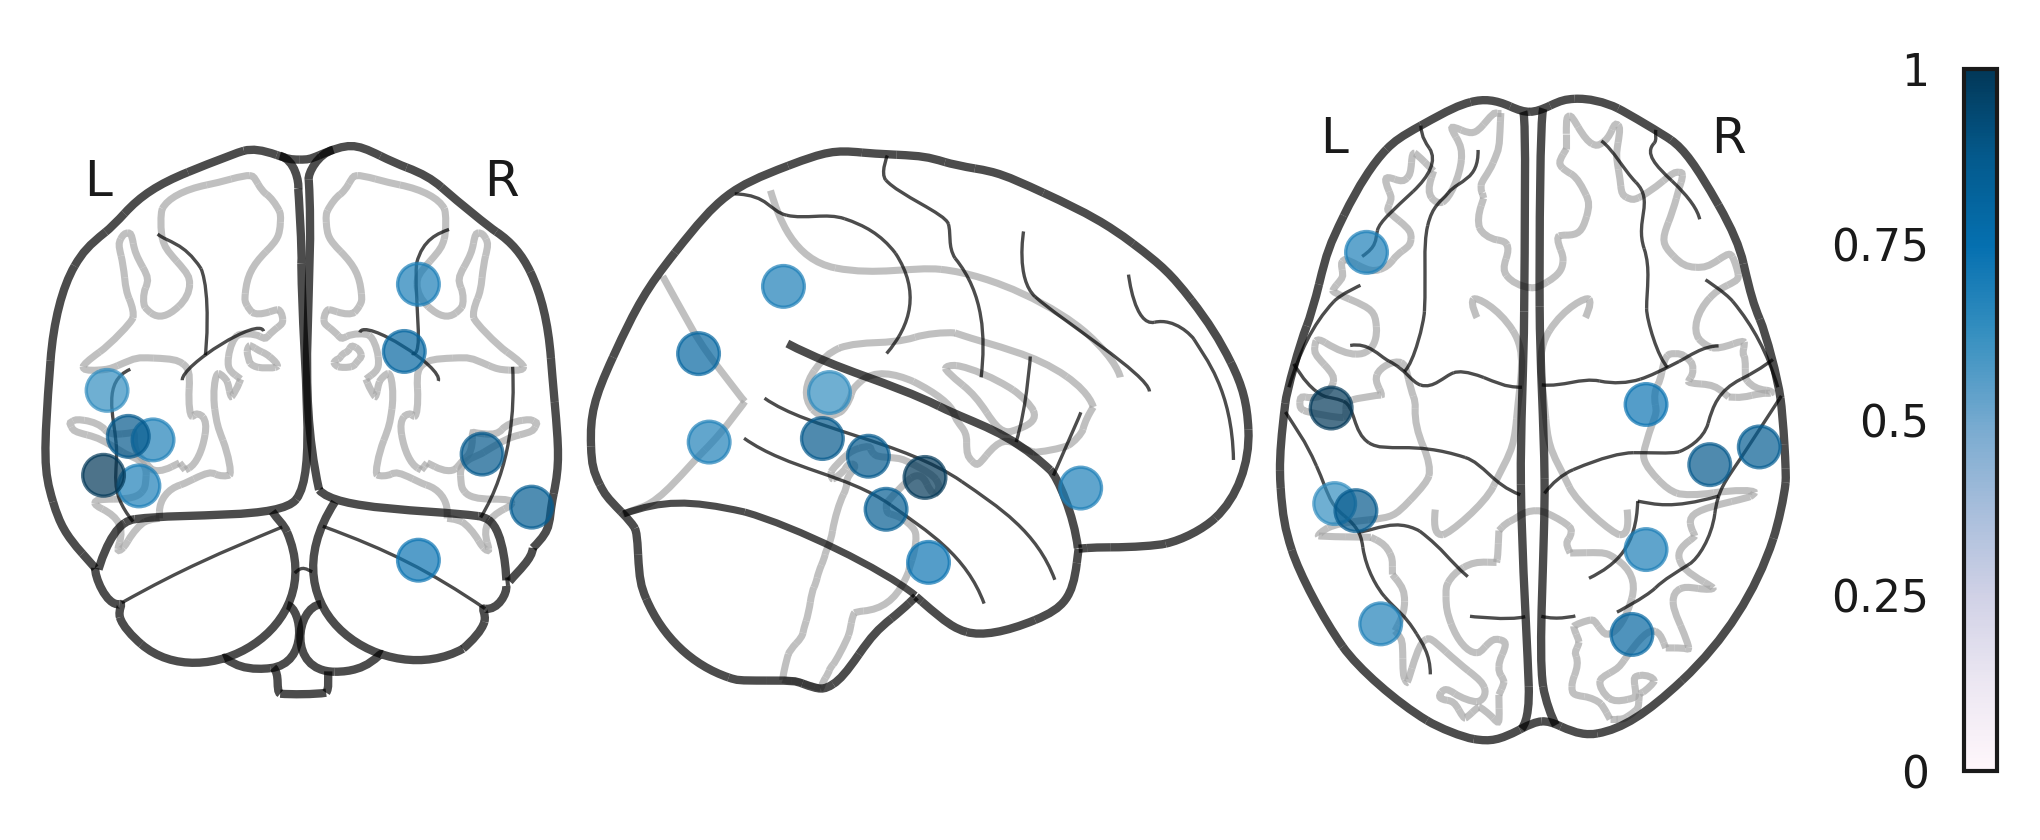

In [21]:
from nilearn import plotting, datasets
from common.calculation import get_k_argmax
from common.plotting import create_power_fc_matrix, convert_fc_to_node_strength

power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T
matrix = create_power_fc_matrix(pls_coef)

# clip connectivity matrix to preserve positive and negative edges
positive_edges = np.clip(matrix, 0, matrix.max())
negative_edges = np.clip(matrix, matrix.min(), 0)

# calculate strength for positive edges
node_strength_positive = convert_fc_to_node_strength(positive_edges)

# calculate strength for negative edges
node_strength_negative = convert_fc_to_node_strength(negative_edges)

print(node_strength_positive.shape, node_strength_negative.shape)
top_pos_nodes = get_k_argmax(node_strength_positive, 10)
top_neg_nodes = get_k_argmax(node_strength_negative, 10)

print(coords[top_pos_nodes], node_strength_positive[top_pos_nodes])
print(coords[top_neg_nodes], node_strength_negative[top_neg_nodes])

plotting.plot_markers(node_strength_positive[top_pos_nodes], coords[top_pos_nodes],
                      node_vmin=0, node_vmax=1, node_cmap="YlOrRd")
plotting.plot_markers(node_strength_negative[top_neg_nodes], coords[top_neg_nodes],
                      node_vmin=0, node_vmax=1, node_cmap="PuBu")

### Compare ages

In [36]:
from common.calculation import (
    calc_cosine_similarity, calc_norm_euclidean, compare_age_similarity)
from common.plotting import plot_age_comparisons

In [37]:
all_ages = mi.inverse_transform(avg_coef.T)[0]

In [41]:
bin_1 = mi_bin_1.inverse_transform(avg_coef.T)[0]

In [43]:
bin_2 = mi_bin_2.inverse_transform(avg_coef.T)[0]

In [45]:
bin_3 = mi_bin_3.inverse_transform(avg_coef.T)[0]

In [56]:
all_ages_s, bin_1_s, bin_2_s, bin_3_s = np.clip(all_ages, np.min(all_ages), 0), np.clip(bin_1, np.min(bin_1), 0), np.clip(bin_2, np.min(bin_2), 0), np.clip(bin_3, np.min(bin_3), 0)

[[1.         0.10837503 0.07464222 0.02468051]
 [0.10837503 1.         0.03270236 0.01762623]
 [0.07464222 0.03270236 1.         0.03451587]
 [0.02468051 0.01762623 0.03451587 1.        ]]


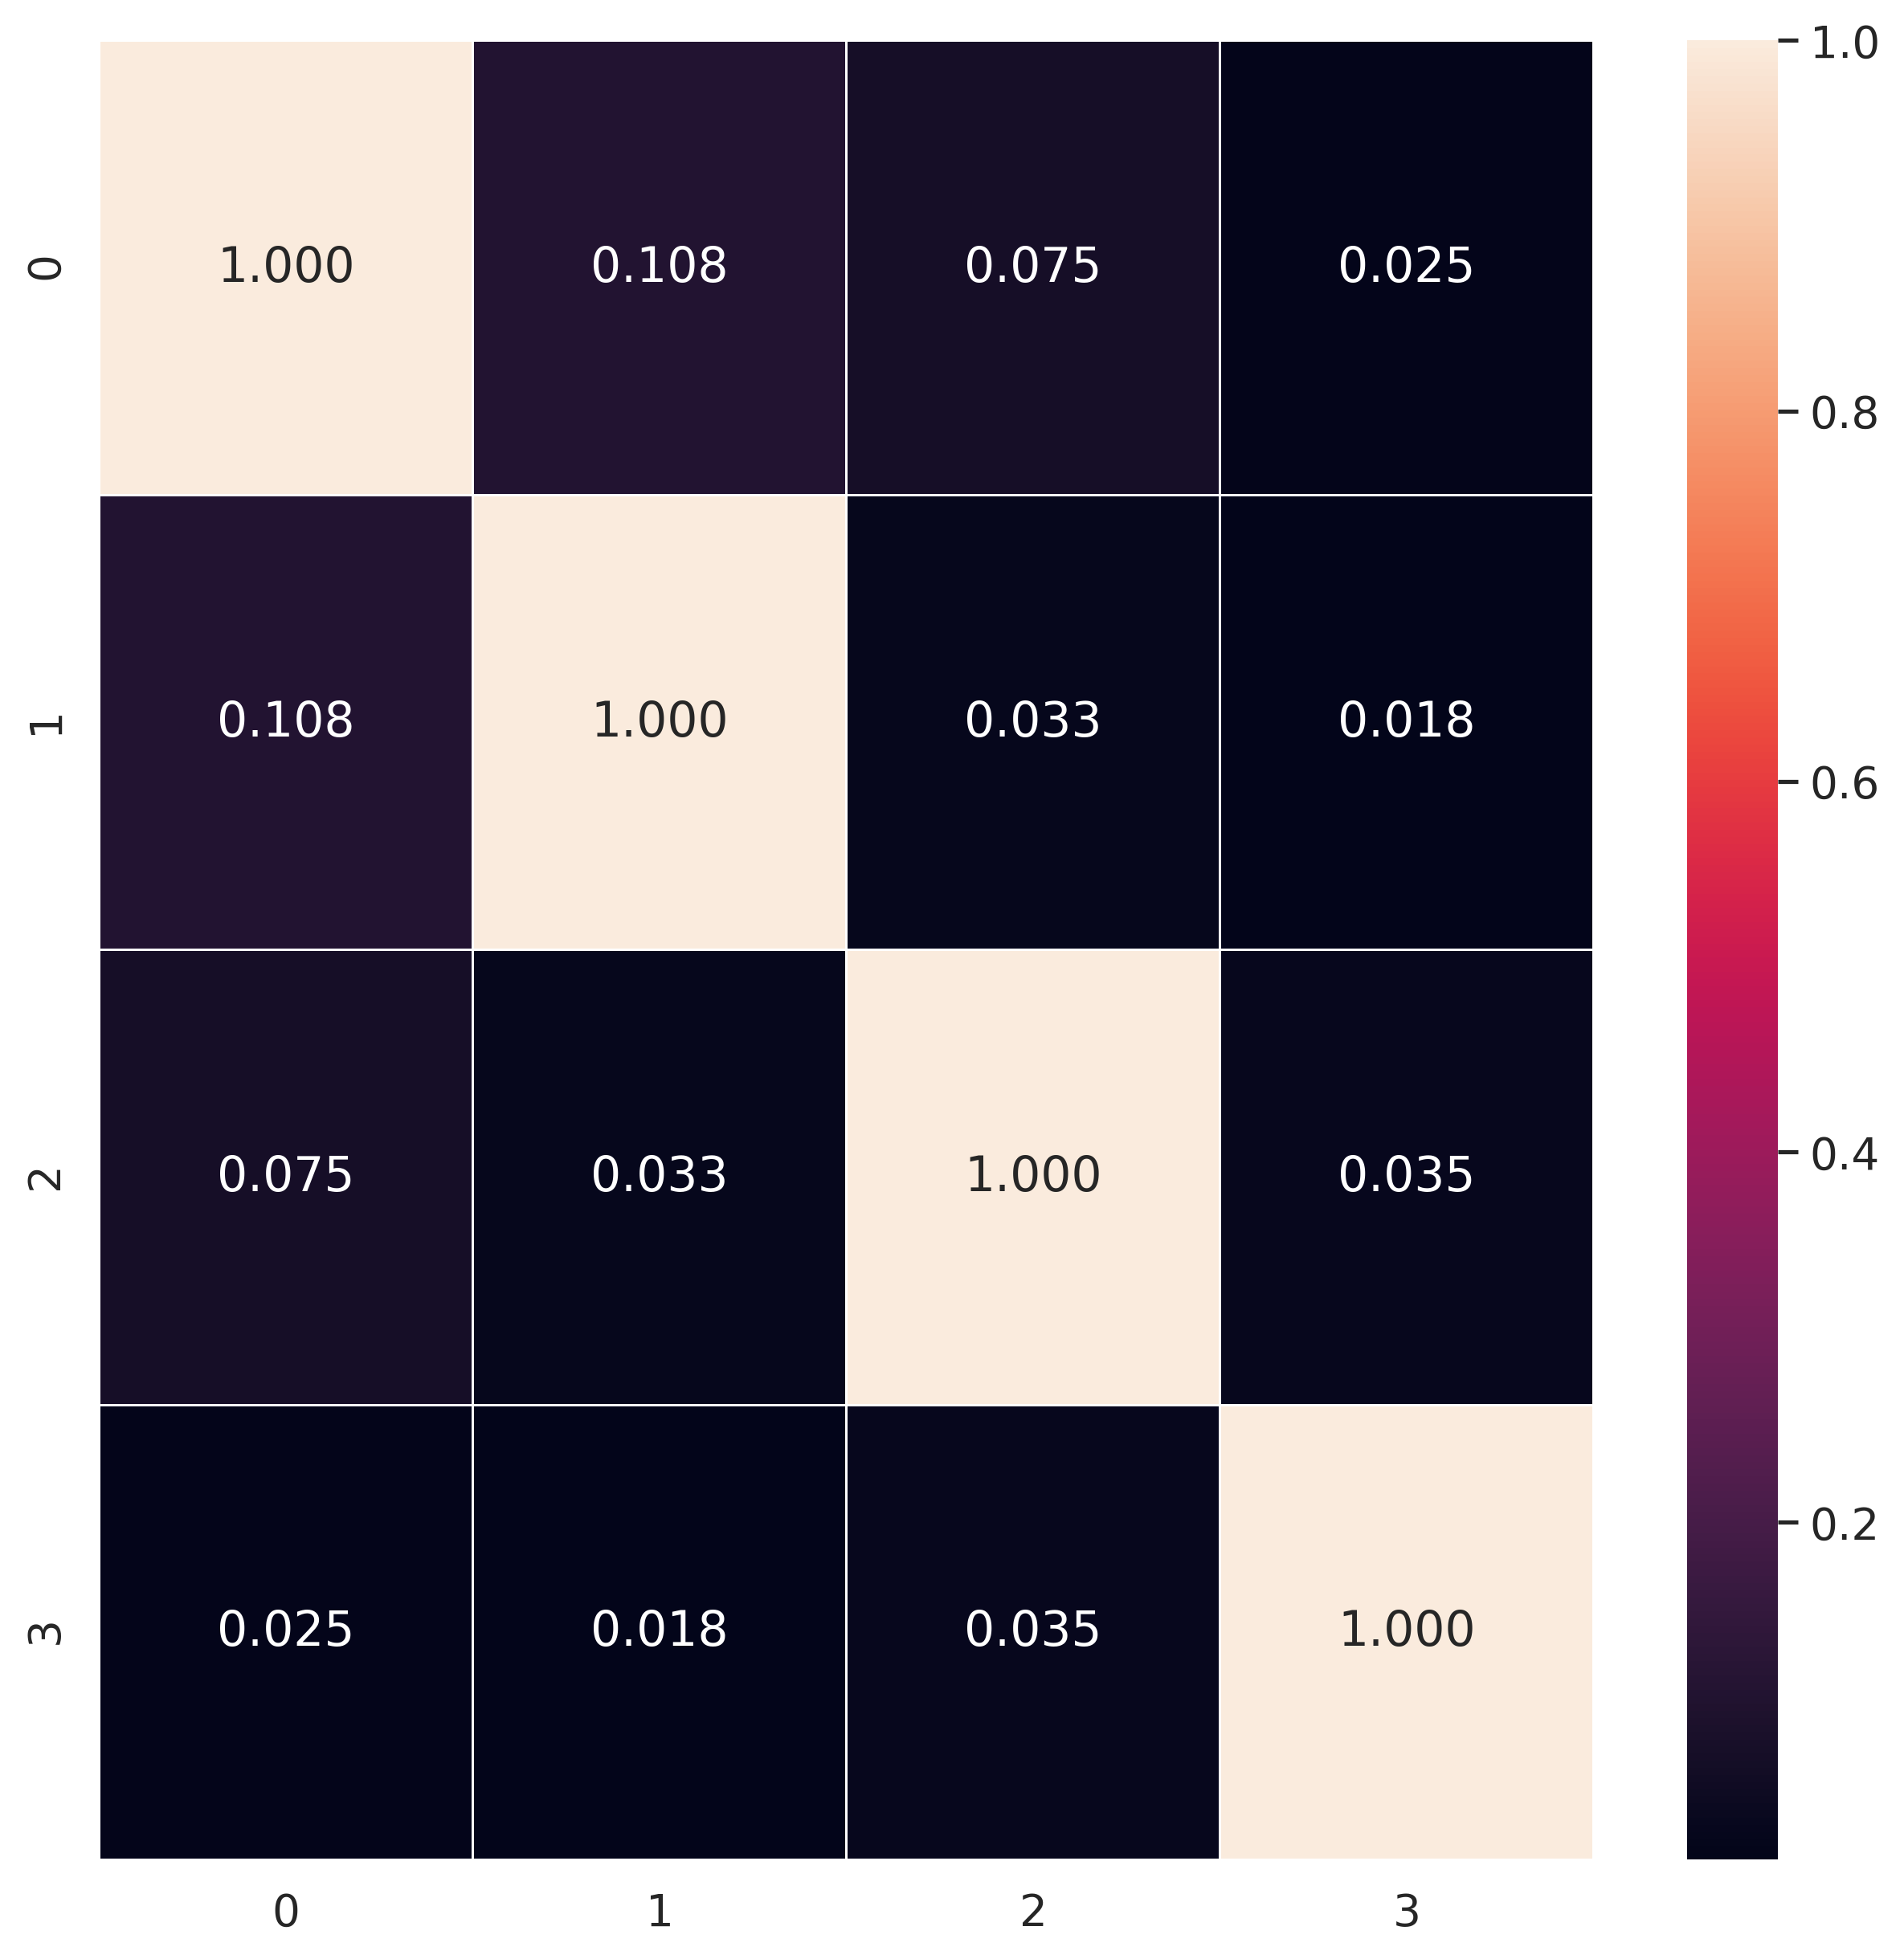

In [57]:
comparisons = compare_age_similarity(all_ages_s, bin_1_s, bin_2_s, bin_3_s, calc_cosine_similarity)
np.fill_diagonal(comparisons, 1)
print(comparisons)
plot_age_comparisons(comparisons)

In [51]:
distance_func = stats.spearmanr

print(distance_func(all_ages, bin_1))
print(distance_func(all_ages, bin_2))
print(distance_func(all_ages, bin_3))
print(distance_func(bin_1, bin_2))
print(distance_func(bin_1, bin_3))
print(distance_func(bin_2, bin_3))

SpearmanrResult(correlation=0.04839780724742265, pvalue=1.8375564055331053e-19)
SpearmanrResult(correlation=0.06770822451095877, pvalue=1.4502789570195166e-36)
SpearmanrResult(correlation=0.02549822337249106, pvalue=2.019240964563468e-06)
SpearmanrResult(correlation=0.011898695973375492, pvalue=0.02662370222138213)
SpearmanrResult(correlation=0.0055914921018586205, pvalue=0.2975089091639709)
SpearmanrResult(correlation=0.003062358126750857, pvalue=0.5682935956922676)
